## APPROACH 1: TRAIN FROM SCRATCH (RESNET-18 / VIT-SMALL)

In [0]:
%pip install opencv-python-headless openpyxl albumentations torch torchvision timm --quiet

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
optuna 3.6.1 requires alembic>=1.5.0, which is not installed.
composer 0.29.0 requires numpy<2.2.0,>=1.21.5, but you have numpy 2.2.6 which is incompatible.
contourpy 1.2.0 requires numpy<2.0,>=1.20, but you have numpy 2.2.6 which is incompatible.
mosaicml-streaming 0.11.0 requires numpy<2.2.0,>=1.21.5, but you have numpy 2.2.6 which is incompatible.
numba 0.59.1 requires numpy<1.27,>=1.22, but you have numpy 2.2.6 which is incompatible.
pyarrow 15.0.2 requires numpy<2,>=1.16.6, but you have numpy 2.2.6 which is incompatible.
pywavelets 1.5.0 requires numpy<2.0,>=1.22.4, but you have numpy 2.2.6 which is incompatible.
tensorflow 2.17.0 requires numpy<2.0.0,>=1.26.0; python_version >= "3.12", but you have numpy 2.2.6 which is incompatible.
thinc 8.2.5 requires numpy<2.0.0,>=1.19.0; python_version >= "3.9", but you 


## MODULE 0: CONFIGURATION & DATA LOADING

In [0]:
import os
import re
import json
import random
import hashlib
from pathlib import Path
from collections import Counter, defaultdict
from typing import List, Dict, Tuple, Optional

import numpy as np
import pandas as pd
import cv2
from PIL import Image
import matplotlib.pyplot as plt

# Set random seeds for reproducibility
RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

print("✓ Libraries imported")

# ================== CONFIGURATION ==================
class Config:
    # Base paths
    BASE_DBFS = "dbfs:/mnt/playbehavior/Fine_tuning"
    
    # Metadata paths
    METADATA_A = f"{BASE_DBFS}/Verified Lables/mmcows.xlsx"
    METADATA_B = f"{BASE_DBFS}/Verified Lables/PlayBehavior.xlsx"
    
    # Cropped images directories
    MMCOWS_CROPS_DBFS = f"{BASE_DBFS}/mmcows/visual_data/visual_data/images/Cropped Images"
    PLAYBEHAVIOR_CROPS_DBFS = f"{BASE_DBFS}/Playbehavior"
    
    # Behavior labels
    MMCOWS_LABELS = ["Drinking", "Feeding head up", "Feeding head down", "Lying", "Standing", "Walking"]
    PLAYBEHAVIOR_LABELS = ["gallop", "leap", "frontal_pushing"]
    ALL_LABELS = MMCOWS_LABELS + PLAYBEHAVIOR_LABELS
    
    # Dataset parameters
    TRAIN_SAMPLES_PER_LABEL = 300
    AUGMENTED_SAMPLES_PER_LABEL = 900
    IMAGE_SIZE = 224
    
    # Verification priority
    VERIFICATION_PRIORITY = {1: 0, 3: 1, 2: 2}
    
    # Output paths for processed datasets
    OUTPUT_BASE = f"{BASE_DBFS}/Processed_Datasets"
    TRAIN_DATASET_PATH = f"{OUTPUT_BASE}/train_dataset.csv"
    TEST_MMCOWS_DATASET_PATH = f"{OUTPUT_BASE}/test_mmcows_dataset.csv"
    TEST_PLAYBEHAVIOR_DATASET_PATH = f"{OUTPUT_BASE}/test_playbehavior_dataset.csv"

# ================== UTILITY FUNCTIONS ==================
def dbfs_to_local(path: str) -> str:
    """Convert DBFS path to local /dbfs path"""
    if path.startswith("dbfs:/"):
        return "/dbfs" + path[5:]
    return path

def local_to_dbfs(path: str) -> str:
    """Convert local /dbfs path to DBFS URI"""
    if path.startswith("/dbfs/"):
        return "dbfs:" + path[5:]
    return path

def ensure_local_path(path: str) -> str:
    """Ensure path is in local /dbfs format"""
    if pd.isna(path) or not isinstance(path, str):
        return ""
    return dbfs_to_local(path)

def check_image_exists(path: str) -> bool:
    """Check if image file exists and is readable"""
    local_path = ensure_local_path(path)
    if not local_path or not os.path.exists(local_path):
        return False
    try:
        img = Image.open(local_path)
        img.verify()
        return True
    except:
        return False

def load_image_cv2(path: str) -> Optional[np.ndarray]:
    """Load image using OpenCV"""
    local_path = ensure_local_path(path)
    if not local_path or not os.path.exists(local_path):
        return None
    img = cv2.imread(local_path)
    if img is not None:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

def load_image_pil(path: str) -> Optional[Image.Image]:
    """Load image using PIL"""
    local_path = ensure_local_path(path)
    if not local_path or not os.path.exists(local_path):
        return None
    try:
        return Image.open(local_path).convert('RGB')
    except:
        return None

print("✓ Configuration and utilities loaded")
print(f"  - Training samples per label: {Config.TRAIN_SAMPLES_PER_LABEL}")
print(f"  - Target augmented samples: {Config.AUGMENTED_SAMPLES_PER_LABEL}")
print(f"  - Total labels: {len(Config.ALL_LABELS)}")

# ================== RELOAD DATASETS ==================
print("="*60)
print("RELOADING ALL SAVED DATASETS")
print("="*60)

# Check if datasets exist
train_csv_path = dbfs_to_local(Config.TRAIN_DATASET_PATH)
mmcows_test_csv_path = dbfs_to_local(Config.TEST_MMCOWS_DATASET_PATH)
playbehavior_test_csv_path = dbfs_to_local(Config.TEST_PLAYBEHAVIOR_DATASET_PATH)

datasets_exist = {
    'train': os.path.exists(train_csv_path),
    'mmcows_test': os.path.exists(mmcows_test_csv_path),
    'playbehavior_test': os.path.exists(playbehavior_test_csv_path)
}

print("\n📂 Dataset Files Status:")
for name, exists in datasets_exist.items():
    status = "✓ Found" if exists else "✗ Missing"
    print(f"  {name:20s}: {status}")

if not all(datasets_exist.values()):
    raise FileNotFoundError("Some dataset files are missing! Please rerun Modules 1-4")

print("\n✓ All dataset files found! Loading...")

# Load Training Dataset
print("\n[1/3] Loading training dataset...")
train_df = pd.read_csv(train_csv_path)
print(f"  ✓ Loaded: {len(train_df):,} samples")
print(f"    - Labels: {sorted(train_df['label'].unique())}")
print(f"    - Sources: {train_df['source'].unique().tolist()}")

# Load MMcows Test Dataset
print("\n[2/3] Loading MMcows test dataset...")
mmcows_test_df = pd.read_csv(mmcows_test_csv_path)
print(f"  ✓ Loaded: {len(mmcows_test_df):,} samples")
print(f"    - Labels: {sorted(mmcows_test_df['label'].unique())}")

# Load PlayBehavior Test Dataset
print("\n[3/3] Loading PlayBehavior test dataset...")
playbehavior_test_df = pd.read_csv(playbehavior_test_csv_path)
print(f"  ✓ Loaded: {len(playbehavior_test_df):,} samples")
print(f"    - Labels: {sorted(playbehavior_test_df['label'].unique())}")

# Combine test datasets
combined_test_df = pd.concat([mmcows_test_df, playbehavior_test_df], ignore_index=True)
print(f"\n✓ Combined test dataset: {len(combined_test_df):,} samples")

print("\n" + "="*60)

# ================== QUICK VALIDATION ==================
print("="*60)
print("QUICK VALIDATION")
print("="*60)

train_paths = set(train_df['image_path'].values)
test_paths = set(combined_test_df['image_path'].values)
overlap = train_paths & test_paths

print(f"\n🔍 Train/Test Overlap Check:")
print(f"  - Training paths: {len(train_paths):,}")
print(f"  - Test paths: {len(test_paths):,}")
print(f"  - Overlap: {len(overlap):,}")

if len(overlap) == 0:
    print("  ✓ PASS: No overlap between train and test")
else:
    print("  ✗ FAIL: Found overlapping samples!")
    print(f"    First few overlaps: {list(overlap)[:5]}")

# Check label consistency
train_labels = set(train_df['label'].unique())
test_labels = set(combined_test_df['label'].unique())

print(f"\n🏷️  Label Consistency Check:")
print(f"  - Training labels: {len(train_labels)}")
print(f"  - Test labels: {len(test_labels)}")

if train_labels == test_labels:
    print("  ✓ PASS: Same labels in train and test")
else:
    missing_in_test = train_labels - test_labels
    missing_in_train = test_labels - train_labels
    if missing_in_test:
        print(f"  ⚠️  Labels in train but not test: {missing_in_test}")
    if missing_in_train:
        print(f"  ⚠️  Labels in test but not train: {missing_in_train}")

print("\n" + "="*60)
print("✓ VALIDATION COMPLETE")
print("="*60)

# ================== CREATE TRAIN/VAL SPLIT (80/20) ==================
print("="*60)
print("CREATING TRAIN/VALIDATION SPLIT (80/20)")
print("="*60)

from sklearn.model_selection import train_test_split

# Stratified split to maintain class balance
train_split_df, val_split_df = train_test_split(
    train_df,
    test_size=0.2,  # 20% for validation
    stratify=train_df['label'],
    random_state=42
)

print(f"Original training set: {len(train_df)} samples")
print(f"  → Train split: {len(train_split_df)} samples (240 per class)")
print(f"  → Val split: {len(val_split_df)} samples (60 per class)")

print("\nTrain split distribution:")
for label, count in train_split_df['label'].value_counts().sort_index().items():
    print(f"  {label:25s}: {count:3d}")

print("\nValidation split distribution:")
for label, count in val_split_df['label'].value_counts().sort_index().items():
    print(f"  {label:25s}: {count:3d}")

# Save splits to CSV
train_split_path = dbfs_to_local(f"{Config.OUTPUT_BASE}/train_split.csv")
val_split_path = dbfs_to_local(f"{Config.OUTPUT_BASE}/val_split.csv")

train_split_df.to_csv(train_split_path, index=False)
val_split_df.to_csv(val_split_path, index=False)

print(f"\n✓ Saved train split: {local_to_dbfs(train_split_path)}")
print(f"✓ Saved val split: {local_to_dbfs(val_split_path)}")
print("="*60)

✓ Libraries imported
✓ Configuration and utilities loaded
  - Training samples per label: 300
  - Target augmented samples: 900
  - Total labels: 9
RELOADING ALL SAVED DATASETS

📂 Dataset Files Status:
  train               : ✓ Found
  mmcows_test         : ✓ Found
  playbehavior_test   : ✓ Found

✓ All dataset files found! Loading...

[1/3] Loading training dataset...
  ✓ Loaded: 2,700 samples
    - Labels: ['Drinking', 'Feeding head down', 'Feeding head up', 'Lying', 'Standing', 'Walking', 'frontal_pushing', 'gallop', 'leap']
    - Sources: ['mmcows', 'playbehavior']

[2/3] Loading MMcows test dataset...
  ✓ Loaded: 209,881 samples
    - Labels: ['Drinking', 'Feeding head down', 'Feeding head up', 'Lying', 'Standing', 'Walking']

[3/3] Loading PlayBehavior test dataset...
  ✓ Loaded: 1,919 samples
    - Labels: ['frontal_pushing', 'gallop', 'leap']

✓ Combined test dataset: 211,800 samples

QUICK VALIDATION

🔍 Train/Test Overlap Check:
  - Training paths: 2,700
  - Test paths: 211,80

## MODULE 5: AUGMENTATION PIPELINE

In [0]:
import torch
import torchvision.transforms as T
from torchvision.transforms import functional as TF
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
import numpy as np
from typing import Optional, Tuple, Dict, Any

class AugmentationPipeline:
    """
    Comprehensive augmentation pipeline for cow behavior images
    Uses albumentations for diverse and efficient augmentation
    """
    
    def __init__(self, 
                 image_size: int = 224,
                 mode: str = 'train',
                 augmentation_strength: str = 'medium'):
        """
        Args:
            image_size: Target image size (default 224 for most models)
            mode: 'train', 'val', or 'test'
            augmentation_strength: 'light', 'medium', or 'heavy'
        """
        self.image_size = image_size
        self.mode = mode
        self.augmentation_strength = augmentation_strength
        
        # Build augmentation pipeline based on mode
        if mode == 'train':
            self.transform = self._build_train_transform()
        else:
            self.transform = self._build_eval_transform()
    
    def _build_train_transform(self) -> A.Compose:
        """Build training augmentation pipeline"""
        
        # Define augmentation strength parameters
        if self.augmentation_strength == 'light':
            brightness_limit = 0.1
            contrast_limit = 0.1
            rotation_limit = 10
            scale_range = (0.9, 1.1)
        elif self.augmentation_strength == 'medium':
            brightness_limit = 0.2
            contrast_limit = 0.2
            rotation_limit = 15
            scale_range = (0.8, 1.2)
        else:  # heavy
            brightness_limit = 0.3
            contrast_limit = 0.3
            rotation_limit = 20
            scale_range = (0.7, 1.3)
        
        transform = A.Compose([
            # Geometric transformations
            A.HorizontalFlip(p=0.5),
            A.Rotate(limit=rotation_limit, p=0.5),
            A.ShiftScaleRotate(
                shift_limit=0.1,
                scale_limit=(scale_range[0]-1, scale_range[1]-1),
                rotate_limit=rotation_limit,
                border_mode=cv2.BORDER_CONSTANT,
                value=0,
                p=0.5
            ),
            A.Perspective(scale=(0.05, 0.1), p=0.3),
            
            # Color transformations
            A.OneOf([
                A.RandomBrightnessContrast(
                    brightness_limit=brightness_limit,
                    contrast_limit=contrast_limit,
                    p=1.0
                ),
                A.HueSaturationValue(
                    hue_shift_limit=10,
                    sat_shift_limit=20,
                    val_shift_limit=20,
                    p=1.0
                ),
                A.ColorJitter(
                    brightness=brightness_limit,
                    contrast=contrast_limit,
                    saturation=0.2,
                    hue=0.1,
                    p=1.0
                ),
            ], p=0.8),
            
            # Noise and blur
            A.OneOf([
                A.GaussNoise(var_limit=(10.0, 50.0), p=1.0),
                A.GaussianBlur(blur_limit=(3, 5), p=1.0),
                A.MotionBlur(blur_limit=5, p=1.0),
            ], p=0.3),
            
            # Advanced augmentations to force the model to look at the whole picture
            A.CoarseDropout(
                max_holes=8,
                max_height=int(0.1 * self.image_size),
                max_width=int(0.1 * self.image_size),
                min_holes=1,
                fill_value=0,
                p=0.2
            ),
            
            # Resize and normalize
            A.Resize(self.image_size, self.image_size),
            A.Normalize(
                mean=[0.485, 0.456, 0.406],  # ImageNet stats
                std=[0.229, 0.224, 0.225],
            ),
            ToTensorV2(),
        ])
        
        return transform
    
    def _build_eval_transform(self) -> A.Compose:
        """Build evaluation (validation/test) transform - no augmentation"""
        transform = A.Compose([
            A.Resize(self.image_size, self.image_size),
            A.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
            ToTensorV2(),
        ])
        
        return transform
    
    def __call__(self, image: np.ndarray) -> torch.Tensor:
        """
        Apply transformation to image
        
        Args:
            image: numpy array in RGB format (H, W, C)
        
        Returns:
            Transformed image as PyTorch tensor
        """
        if not isinstance(image, np.ndarray):
            raise TypeError(f"Expected numpy array, got {type(image)}")
        
        # Ensure image is in correct format
        if image.dtype != np.uint8:
            image = (image * 255).astype(np.uint8) if image.max() <= 1.0 else image.astype(np.uint8)
        
        # Apply transformations
        transformed = self.transform(image=image)
        return transformed['image']
    
    def get_params_summary(self) -> Dict[str, Any]:
        """Get summary of augmentation parameters"""
        return {
            'mode': self.mode,
            'image_size': self.image_size,
            'augmentation_strength': self.augmentation_strength,
            'num_transforms': len(self.transform.transforms) if hasattr(self.transform, 'transforms') else 0
        }


print("="*60)
print("AUGMENTATION PIPELINE")
print("="*60)

# Create pipelines for different modes
train_aug = AugmentationPipeline(image_size=224, mode='train', augmentation_strength='medium')
test_aug = AugmentationPipeline(image_size=224, mode='test')

print("\n✓ Training augmentation pipeline:")
print(f"  - Image size: {train_aug.image_size}")
print(f"  - Mode: {train_aug.mode}")
print(f"  - Strength: {train_aug.augmentation_strength}")
print(f"  - Transforms: {len(train_aug.transform.transforms)}")

print("\n✓ Test/validation pipeline:")
print(f"  - Image size: {test_aug.image_size}")
print(f"  - Mode: {test_aug.mode}")
print(f"  - Transforms: {len(test_aug.transform.transforms)} (resize + normalize only)")

print("\n" + "="*60)
print("Ready for dataset integration!")
print("="*60)

AUGMENTATION PIPELINE

✓ Training augmentation pipeline:
  - Image size: 224
  - Mode: train
  - Strength: medium
  - Transforms: 10

✓ Test/validation pipeline:
  - Image size: 224
  - Mode: test
  - Transforms: 3 (resize + normalize only)

Ready for dataset integration!


/local_disk0/.ephemeral_nfs/envs/pythonEnv-4b0e3fae-be9a-4671-be08-71ed9fed165a/lib/python3.12/site-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/root/.ipykernel/1097/command-3487203356064554-1029106348:60: UserWarning: Argument(s) 'value' are not valid for transform ShiftScaleRotate
  A.ShiftScaleRotate(
/root/.ipykernel/1097/command-3487203356064554-1029106348:94: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(10.0, 50.0), p=1.0),
/root/.ipykernel/1097/command-3487203356064554-1029106348:100: UserWarning: Argument(s) 'max_holes, max_height, max_width, min_holes, fill_value' are not valid for transform CoarseDropout
  A.CoarseDropout(


## MODULE 6: PYTORCH DATASET & DATALOADER (UPDATED FOR 3× AUGMENTATION)

In [0]:

from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from typing import Optional, Callable, Dict, Tuple
import pandas as pd
from collections import Counter

class CowBehaviorDataset(Dataset):
    """
    Dataset with on-the-fly 3× augmentation for training:
    - Returns 3 versions: original + 2 augmented
    - Effectively 3× the dataset size
    """
    
    def __init__(self,
                 metadata_df: pd.DataFrame,
                 transform: Optional[Callable] = None,
                 image_size: int = 224,
                 mode: str = 'train',
                 augmentation_strength: str = 'medium',
                 label_to_idx: Optional[Dict[str, int]] = None,
                 augmentation_multiplier: int = 3):
        """
        Args:
            augmentation_multiplier: Number of versions per image (1=original only, 3=original+2 augmented)
        """
        self.metadata_df = metadata_df.reset_index(drop=True)
        self.image_size = image_size
        self.mode = mode
        # self.augmentation_multiplier = augmentation_multiplier if mode == 'train' else 1
        self.augmentation_multiplier = augmentation_multiplier

        # Create label mapping
        if label_to_idx is None:
            unique_labels = sorted(self.metadata_df['label'].unique())
            self.label_to_idx = {label: idx for idx, label in enumerate(unique_labels)}
        else:
            self.label_to_idx = label_to_idx
        
        self.idx_to_label = {idx: label for label, idx in self.label_to_idx.items()}
        self.num_classes = len(self.label_to_idx)
        
        # # Setup transforms
        # # For training: need both non-augmented (for original) and augmented transforms
        # if mode == 'train':
        #     self.transform_original = AugmentationPipeline(
        #         image_size=image_size,
        #         mode='test',  # No augmentation for "original" version
        #         augmentation_strength=augmentation_strength
        #     )
        #     self.transform_augmented = AugmentationPipeline(
        #         image_size=image_size,
        #         mode='train',  # With augmentation
        #         augmentation_strength=augmentation_strength
        #     )
        # else:
        #     # Val/test: no augmentation
        #     if transform is not None:
        #         self.transform_original = transform
        #     else:
        #         self.transform_original = AugmentationPipeline(
        #             image_size=image_size,
        #             mode='test'
        #         )
                
        # Setup transforms
        # For training or augmented validation:
        if mode == 'train' or (mode == 'val' and self.augmentation_multiplier > 1):
            self.transform_original = AugmentationPipeline(
                image_size=image_size,
                mode='test',  # No augmentation for "original" version
                augmentation_strength=augmentation_strength
            )
            self.transform_augmented = AugmentationPipeline(
                image_size=image_size,
                mode='train',  # With augmentation
                augmentation_strength=augmentation_strength
            )
        else:
            # Standard val/test: no augmentation
            if transform is not None:
                self.transform_original = transform
            else:
                self.transform_original = AugmentationPipeline(
                    image_size=image_size,
                    mode='test'
                )
        
        # Cache for failed image loads
        self._failed_indices = set()
        
        print(f"[{mode.upper()} Dataset] Initialized")
        print(f"  - Physical samples: {len(self.metadata_df)}")
        print(f"  - Augmentation multiplier: {self.augmentation_multiplier}×")
        print(f"  - Effective samples: {len(self)} (what DataLoader sees)")
        print(f"  - Number of classes: {self.num_classes}")
    
    def __len__(self) -> int:
        """
        Return effective dataset size (physical samples × augmentation multiplier)
        This makes DataLoader iterate through all augmented versions
        """
        return len(self.metadata_df) * self.augmentation_multiplier
    
    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, int, Dict]:
        """
        Get item by index
        
        For training with augmentation_multiplier=3:
        - idx 0, 1, 2 → same image (idx 0), different augmentations
        - idx 3, 4, 5 → same image (idx 1), different augmentations
        
        Returns:
            image: Transformed image tensor (C, H, W)
            label: Label index
            metadata: Dictionary with additional info
        """
        # Map augmented index to physical sample index
        physical_idx = idx // self.augmentation_multiplier
        augmentation_idx = idx % self.augmentation_multiplier
        
        if physical_idx in self._failed_indices:
            # Return a random valid index if this one previously failed
            new_idx = np.random.randint(0, len(self))
            return self.__getitem__(new_idx)
        
        try:
            row = self.metadata_df.iloc[physical_idx]
            
            # Load image
            image_path = row['image_path']
            image = load_image_cv2(image_path)  # Returns RGB numpy array
            
            if image is None:
                self._failed_indices.add(physical_idx)
                # Fallback to random valid sample
                return self.__getitem__(np.random.randint(0, len(self)))
            
            # Get label
            label_str = row['label']
            label_idx = self.label_to_idx[label_str]
            
            # Apply transforms based on augmentation index
            # if self.mode == 'train':
            #     if augmentation_idx == 0:
            #         # Original (no augmentation)
            #         image_tensor = self.transform_original(image)
            #     else:
            #         # Augmented versions
            #         image_tensor = self.transform_augmented(image)
            # else:
            #     # Val/test: always use original transform
            #     image_tensor = self.transform_original(image)
            
            # Apply transforms based on augmentation index
            if self.mode == 'train' or (self.mode == 'val' and self.augmentation_multiplier > 1):
                if augmentation_idx == 0:
                    # Original (no augmentation)
                    image_tensor = self.transform_original(image)
                else:
                    # Augmented versions
                    image_tensor = self.transform_augmented(image)
            else:
                # Standard Val/test: always use original transform
                image_tensor = self.transform_original(image)

            # Metadata
            metadata = {
                'idx': idx,
                'physical_idx': physical_idx,
                'augmentation_idx': augmentation_idx,
                'image_path': image_path,
                'label_str': label_str,
                'label_idx': label_idx,
                'source': row.get('source', 'unknown'),
                'cow_id': row.get('cow_id', -1),
            }
            
            return image_tensor, label_idx, metadata
        
        except Exception as e:
            print(f"Error loading sample {idx} (physical {physical_idx}): {e}")
            self._failed_indices.add(physical_idx)
            # Return random valid sample
            return self.__getitem__(np.random.randint(0, len(self)))
    
    def get_label_distribution(self) -> Dict[str, int]:
        """Get distribution of labels in physical dataset"""
        return dict(Counter(self.metadata_df['label']))
    
    def get_class_weights(self) -> torch.Tensor:
        """
        Calculate class weights for balanced training
        Based on physical dataset (not augmented count)
        """
        label_counts = self.metadata_df['label'].value_counts()
        total_samples = len(self.metadata_df)
        
        # Calculate weights (inverse frequency)
        weights = []
        for label in sorted(self.label_to_idx.keys()):
            count = label_counts.get(label, 1)
            weight = total_samples / (len(label_counts) * count)
            weights.append(weight)
        
        return torch.FloatTensor(weights)
    
    def get_sample_weights(self) -> torch.Tensor:
        """
        Get per-sample weights for WeightedRandomSampler
        Returns weights for EFFECTIVE dataset size (with augmentation)
        """
        class_weights = self.get_class_weights()
        sample_weights = []
        
        for _ in range(self.augmentation_multiplier):
            for _, row in self.metadata_df.iterrows():
                label_idx = self.label_to_idx[row['label']]
                sample_weights.append(class_weights[label_idx].item())
        
        return torch.FloatTensor(sample_weights)


def create_dataloaders(train_df: pd.DataFrame,
                       val_df: pd.DataFrame,
                       test_df: Optional[pd.DataFrame] = None,
                       batch_size: int = 32,
                       num_workers: int = 4,
                       image_size: int = 224,
                       use_weighted_sampling: bool = False,
                       augmentation_strength: str = 'medium',
                       augmentation_multiplier: int = 3, val_augmentation_multiplier: int = 1) -> Dict[str, DataLoader]:
    """
    Create PyTorch DataLoaders with 3× augmentation for training
    
    Args:
        train_df: Training metadata DataFrame (will be augmented 3×)
        val_df: Validation metadata DataFrame (no augmentation)
        test_df: Test metadata DataFrame (optional, no augmentation)
        augmentation_multiplier: Number of versions per training image (3 = 900 total)
    """
    
    # Create label mapping from all data
    all_labels = set(train_df['label'].unique())
    all_labels.update(val_df['label'].unique())
    if test_df is not None:
        all_labels.update(test_df['label'].unique())
    
    label_to_idx = {label: idx for idx, label in enumerate(sorted(all_labels))}
    
    # Create training dataset (with 3× augmentation)
    train_dataset = CowBehaviorDataset(
        train_df,
        image_size=image_size,
        mode='train',
        augmentation_strength=augmentation_strength,
        label_to_idx=label_to_idx,
        augmentation_multiplier=augmentation_multiplier
    )
    
    # Setup sampler for training
    if use_weighted_sampling:
        sample_weights = train_dataset.get_sample_weights()
        sampler = WeightedRandomSampler(
            weights=sample_weights,
            num_samples=len(sample_weights),
            replacement=True
        )
        shuffle = False
        print("✓ Using WeightedRandomSampler for balanced training")
    else:
        sampler = None
        shuffle = True
    
    # Training dataloader
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        sampler=sampler,
        num_workers=num_workers,
        pin_memory=True,
        drop_last=True
    )
    
    dataloaders = {'train': train_loader}
    
    # # Validation dataloader (NO augmentation)
    # val_dataset = CowBehaviorDataset(
    #     val_df,
    #     image_size=image_size,
    #     mode='val',
    #     label_to_idx=label_to_idx,
    #     augmentation_multiplier=1
    # )
    # Validation dataloader (NOW with controllable augmentation)
    val_dataset = CowBehaviorDataset(
        val_df,
        image_size=image_size,
        mode='val',
        augmentation_strength=augmentation_strength, # Pass strength
        label_to_idx=label_to_idx,
        augmentation_multiplier=val_augmentation_multiplier # Use new param
    )
    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True
    )
    dataloaders['val'] = val_loader
    
    # Test dataloader (if provided)
    if test_df is not None:
        test_dataset = CowBehaviorDataset(
            test_df,
            image_size=image_size,
            mode='test',
            label_to_idx=label_to_idx,
            augmentation_multiplier=1
        )
        test_loader = DataLoader(
            test_dataset,
            batch_size=batch_size,
            shuffle=False,
            num_workers=num_workers,
            pin_memory=True
        )
        dataloaders['test'] = test_loader
    
    return dataloaders


print("="*60)
print("✓ UPDATED DATASET CLASS (3× AUGMENTATION)")
print("="*60)
print("Changes:")
print("  - __len__() returns physical_samples × augmentation_multiplier")
print("  - __getitem__() returns original (idx 0, 3, 6...) or augmented (idx 1,2,4,5...)")
print("  - Training sees 900 samples per class (300 physical × 3)")
print("="*60)

✓ UPDATED DATASET CLASS (3× AUGMENTATION)
Changes:
  - __len__() returns physical_samples × augmentation_multiplier
  - __getitem__() returns original (idx 0, 3, 6...) or augmented (idx 1,2,4,5...)
  - Training sees 900 samples per class (300 physical × 3)


## MODULE 7: VALIDATION & VISUALIZATION

In [0]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
from typing import List
import torch

class DatasetValidator:
    """
    Validate and visualize datasets before training
    """
    
    def __init__(self, train_df: pd.DataFrame, test_df: pd.DataFrame):
        self.train_df = train_df
        self.test_df = test_df
    
    def print_statistics(self):
        """Print comprehensive dataset statistics"""
        print("="*60)
        print("DATASET STATISTICS")
        print("="*60)
        
        print("\n📊 TRAINING SET")
        print("-" * 60)
        print(f"Total samples: {len(self.train_df)}")
        print(f"Number of labels: {self.train_df['label'].nunique()}")
        print(f"Sources: {self.train_df['source'].unique()}")
        
        print("\nSamples per label:")
        for label, count in self.train_df['label'].value_counts().sort_index().items():
            print(f"  {label:25s}: {count:4d}")
        
        print("\nSamples per source:")
        for source, count in self.train_df['source'].value_counts().items():
            print(f"  {source:15s}: {count:4d}")
        
        if 'Verification' in self.train_df.columns:
            print("\nVerification distribution:")
            for ver, count in self.train_df['Verification'].value_counts().sort_index().items():
                pct = 100 * count / len(self.train_df)
                print(f"  Verification {ver}: {count:4d} ({pct:.1f}%)")
        
        print("\n" + "="*60)
        print("📊 TEST SET")
        print("-" * 60)
        print(f"Total samples: {len(self.test_df)}")
        print(f"Number of labels: {self.test_df['label'].nunique()}")
        print(f"Sources: {self.test_df['source'].unique()}")
        
        print("\nSamples per label:")
        for label, count in self.test_df['label'].value_counts().sort_index().items():
            train_count = len(self.train_df[self.train_df['label'] == label])
            ratio = count / train_count if train_count > 0 else 0
            print(f"  {label:25s}: {count:6d} (train:test = 1:{ratio:.1f})")
        
        print("\nSamples per source:")
        for source, count in self.test_df['source'].value_counts().items():
            print(f"  {source:15s}: {count:6d}")
    
    def plot_label_distribution(self, figsize=(14, 6)):
        """Plot label distribution for train and test sets"""
        fig, axes = plt.subplots(1, 2, figsize=figsize)
        
        # Training set
        train_counts = self.train_df['label'].value_counts().sort_index()
        axes[0].bar(range(len(train_counts)), train_counts.values, color='steelblue', alpha=0.7)
        axes[0].set_xticks(range(len(train_counts)))
        axes[0].set_xticklabels(train_counts.index, rotation=45, ha='right')
        axes[0].set_ylabel('Count')
        axes[0].set_title(f'Training Set Distribution\n(Total: {len(self.train_df)} samples)')
        axes[0].grid(axis='y', alpha=0.3)
        
        # Test set
        test_counts = self.test_df['label'].value_counts().sort_index()
        axes[1].bar(range(len(test_counts)), test_counts.values, color='coral', alpha=0.7)
        axes[1].set_xticks(range(len(test_counts)))
        axes[1].set_xticklabels(test_counts.index, rotation=45, ha='right')
        axes[1].set_ylabel('Count')
        axes[1].set_title(f'Test Set Distribution\n(Total: {len(self.test_df)} samples)')
        axes[1].grid(axis='y', alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    def check_data_integrity(self) -> Dict[str, bool]:
        """Check data integrity and return status"""
        checks = {}
        
        # Check 1: No overlap between train and test
        train_paths = set(self.train_df['image_path'])
        test_paths = set(self.test_df['image_path'])
        overlap = train_paths & test_paths
        checks['no_overlap'] = len(overlap) == 0
        
        if not checks['no_overlap']:
            print(f"⚠️  WARNING: {len(overlap)} samples appear in both train and test!")
        else:
            print("✓ No overlap between train and test sets")
        
        # Check 2: All labels present in both sets
        train_labels = set(self.train_df['label'])
        test_labels = set(self.test_df['label'])
        checks['labels_match'] = train_labels == test_labels
        
        if not checks['labels_match']:
            missing_in_test = train_labels - test_labels
            missing_in_train = test_labels - train_labels
            if missing_in_test:
                print(f"⚠️  WARNING: Labels in train but not test: {missing_in_test}")
            if missing_in_train:
                print(f"⚠️  WARNING: Labels in test but not train: {missing_in_train}")
        else:
            print("✓ All labels present in both train and test sets")
        
        # Check 3: Reasonable train/test split ratios
        checks['reasonable_splits'] = True
        for label in train_labels:
            train_count = len(self.train_df[self.train_df['label'] == label])
            test_count = len(self.test_df[self.test_df['label'] == label])
            if test_count == 0:
                print(f"⚠️  WARNING: Label '{label}' has no test samples!")
                checks['reasonable_splits'] = False
        
        if checks['reasonable_splits']:
            print("✓ All labels have test samples")
        
        return checks


def visualize_augmentations(dataset: CowBehaviorDataset, 
                            num_samples: int = 3,
                            num_augmentations: int = 5,
                            figsize=(15, 10)):
    """
    Visualize augmentation effects on random samples
    """
    fig = plt.figure(figsize=figsize)
    gs = GridSpec(num_samples, num_augmentations + 1, figure=fig)
    
    # Denormalize function
    def denormalize(tensor):
        mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
        std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
        tensor = tensor * std + mean
        tensor = torch.clamp(tensor, 0, 1)
        return tensor.permute(1, 2, 0).numpy()
    
    # Get random indices
    indices = np.random.choice(len(dataset), num_samples, replace=False)
    
    for i, idx in enumerate(indices):
        # Get original image (without augmentation)
        row = dataset.metadata_df.iloc[idx]
        original_img = load_image_cv2(row['image_path'])
        label = row['label']
        
        # Show original
        ax = fig.add_subplot(gs[i, 0])
        ax.imshow(original_img)
        ax.set_title(f'Original\n{label}', fontsize=10)
        ax.axis('off')
        
        # Show augmented versions
        for j in range(num_augmentations):
            img_tensor, _, _ = dataset[idx]
            img_np = denormalize(img_tensor)
            
            ax = fig.add_subplot(gs[i, j + 1])
            ax.imshow(img_np)
            ax.set_title(f'Aug {j+1}', fontsize=10)
            ax.axis('off')
    
    plt.suptitle('Augmentation Visualization (Original + 5 Random Augmentations)', 
                 fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()


def test_dataloader_speed(dataloader: DataLoader, num_batches: int = 10):
    """Test dataloader speed"""
    import time
    
    print(f"\n{'='*60}")
    print(f"DATALOADER SPEED TEST")
    print(f"{'='*60}")
    print(f"Batch size: {dataloader.batch_size}")
    print(f"Num workers: {dataloader.num_workers}")
    print(f"Testing {num_batches} batches...")
    
    times = []
    start = time.time()
    
    for i, (images, labels, metadata) in enumerate(dataloader):
        batch_time = time.time()
        
        if i > 0:  # Skip first batch (warmup)
            times.append(batch_time - prev_time)
        
        prev_time = batch_time
        
        if i >= num_batches:
            break
    
    total_time = time.time() - start
    avg_time = np.mean(times) if times else 0
    
    print(f"\nResults:")
    print(f"  Total time: {total_time:.2f}s")
    print(f"  Average time per batch: {avg_time*1000:.1f}ms")
    print(f"  Throughput: {dataloader.batch_size / avg_time:.1f} images/sec")
    print(f"{'='*60}\n")


print("="*60)
print("VALIDATION & VISUALIZATION TOOLS")
print("="*60)
print("✓ DatasetValidator class")
print("✓ Augmentation visualization")
print("✓ Dataloader speed testing")
print("="*60)

VALIDATION & VISUALIZATION TOOLS
✓ DatasetValidator class
✓ Augmentation visualization
✓ Dataloader speed testing


## MODULE 8: MODEL ARCHITECTURES

In [0]:
import mlflow

# Create or get experiment
experiment_name = "/Users/" + spark.sql("SELECT current_user()").collect()[0][0] + "/cow_behavior_from_scratch"

# Try to get existing experiment, create if it doesn't exist
try:
    experiment = mlflow.get_experiment_by_name(experiment_name)
    if experiment is None:
        experiment_id = mlflow.create_experiment(experiment_name)
        print(f"✓ Created new experiment: {experiment_name}")
        print(f"  Experiment ID: {experiment_id}")
    else:
        experiment_id = experiment.experiment_id
        print(f"✓ Found existing experiment: {experiment_name}")
        print(f"  Experiment ID: {experiment_id}")
except Exception as e:
    print(f"Error with experiment: {e}")
    # Fallback to a simpler path
    experiment_name = "/Shared/cow_behavior_from_scratch"
    experiment_id = mlflow.create_experiment(experiment_name)
    print(f"✓ Created experiment at: {experiment_name}")
    print(f"  Experiment ID: {experiment_id}")

# Set the experiment
mlflow.set_experiment(experiment_name)

# Update config
TrainingConfig.EXPERIMENT_NAME = experiment_name

print(f"\n✓ MLflow experiment ready: {experiment_name}")



✓ Found existing experiment: /Users/hy625@cornell.edu/cow_behavior_from_scratch
  Experiment ID: 2824652981993332

✓ MLflow experiment ready: /Users/hy625@cornell.edu/cow_behavior_from_scratch


In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import timm

class ResNet18FromScratch(nn.Module):
    """
    ResNet-18 trained from scratch for cow behavior classification
    """
    
    def __init__(self, num_classes: int = 9, dropout_rate: float = 0.5):
        super(ResNet18FromScratch, self).__init__()
        
        # Load ResNet-18 architecture without pre-trained weights
        self.backbone = models.resnet18(pretrained=False)
        
        # Get feature dimension from final layer
        num_features = self.backbone.fc.in_features
        
        # Replace final FC layer with custom classifier
        self.backbone.fc = nn.Identity()  # Remove original FC
        
        # Custom classification head
        self.classifier = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(num_features, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate / 2),
            nn.Linear(256, num_classes)
        )
        
        self.num_classes = num_classes
        self.num_features = num_features
        
        # Initialize weights using He initialization
        self._initialize_weights()
    
    def _initialize_weights(self):
        """Initialize classifier weights"""
        for m in self.classifier.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        features = self.backbone(x)
        logits = self.classifier(features)
        return logits
    
    def get_embeddings(self, x):
        """Extract feature embeddings (before classifier)"""
        with torch.no_grad():
            features = self.backbone(x)
        return features


class ViTSmallFromScratch(nn.Module):
    """
    Vision Transformer (ViT-Small) trained from scratch for cow behavior classification
    """
    
    def __init__(self, num_classes: int = 9, dropout_rate: float = 0.5, image_size: int = 224):
        super(ViTSmallFromScratch, self).__init__()
        
        # Load ViT-Small architecture without pre-trained weights
        # Using timm library for flexible ViT implementations
        self.backbone = timm.create_model(
            'vit_small_patch16_224',
            pretrained=False,
            num_classes=0,  # Remove classification head
            img_size=image_size
        )
        
        # Get feature dimension
        num_features = self.backbone.num_features
        
        # Custom classification head
        self.classifier = nn.Sequential(
            nn.LayerNorm(num_features),
            nn.Dropout(dropout_rate),
            nn.Linear(num_features, 384),
            nn.GELU(),
            nn.Dropout(dropout_rate / 2),
            nn.Linear(384, num_classes)
        )
        
        self.num_classes = num_classes
        self.num_features = num_features
        
        # Initialize classifier weights
        self._initialize_weights()
    
    def _initialize_weights(self):
        """Initialize classifier weights"""
        for m in self.classifier.modules():
            if isinstance(m, nn.Linear):
                nn.init.trunc_normal_(m.weight, std=0.02)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        features = self.backbone(x)
        logits = self.classifier(features)
        return logits
    
    def get_embeddings(self, x):
        """Extract feature embeddings (before classifier)"""
        with torch.no_grad():
            features = self.backbone(x)
        return features


def create_model(model_name: str, num_classes: int = 9, **kwargs):
    """
    Factory function to create models
    
    Args:
        model_name: 'resnet18' or 'vit_small'
        num_classes: Number of output classes
        **kwargs: Additional arguments (dropout_rate, image_size, etc.)
    
    Returns:
        model: PyTorch model
    """
    if model_name.lower() == 'resnet18':
        model = ResNet18FromScratch(
            num_classes=num_classes,
            dropout_rate=kwargs.get('dropout_rate', 0.5)
        )
    elif model_name.lower() == 'vit_small':
        model = ViTSmallFromScratch(
            num_classes=num_classes,
            dropout_rate=kwargs.get('dropout_rate', 0.5),
            image_size=kwargs.get('image_size', 224)
        )
    else:
        raise ValueError(f"Unknown model: {model_name}. Choose 'resnet18' or 'vit_small'")
    
    return model


def count_parameters(model):
    """Count total and trainable parameters"""
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total_params, trainable_params


# Test model creation
print("="*60)
print("MODEL ARCHITECTURES (FROM SCRATCH)")
print("="*60)

# Create ResNet-18
print("\n[1/2] Creating ResNet-18...")
resnet18 = create_model('resnet18', num_classes=9)
total, trainable = count_parameters(resnet18)
print(f"  ✓ ResNet-18 created")
print(f"    - Total parameters: {total:,}")
print(f"    - Trainable parameters: {trainable:,}")
print(f"    - Feature dimension: {resnet18.num_features}")

# Create ViT-Small
print("\n[2/2] Creating ViT-Small...")
vit_small = create_model('vit_small', num_classes=9)
total, trainable = count_parameters(vit_small)
print(f"  ✓ ViT-Small created")
print(f"    - Total parameters: {total:,}")
print(f"    - Trainable parameters: {trainable:,}")
print(f"    - Feature dimension: {vit_small.num_features}")

# Test forward pass
print("\n🔍 Testing forward pass...")
dummy_input = torch.randn(2, 3, 224, 224)
with torch.no_grad():
    resnet_output = resnet18(dummy_input)
    vit_output = vit_small(dummy_input)

print(f"  ✓ ResNet-18 output shape: {resnet_output.shape} (batch, classes)")
print(f"  ✓ ViT-Small output shape: {vit_output.shape} (batch, classes)")

print("\n" + "="*60)
print("✓ MODELS READY FOR TRAINING")
print("="*60)

MODEL ARCHITECTURES (FROM SCRATCH)

[1/2] Creating ResNet-18...
  ✓ ResNet-18 created
    - Total parameters: 11,310,153
    - Trainable parameters: 11,310,153
    - Feature dimension: 512

[2/2] Creating ViT-Small...


/databricks/python/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/databricks/python/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


  ✓ ViT-Small created
    - Total parameters: 21,817,737
    - Trainable parameters: 21,817,737
    - Feature dimension: 384

🔍 Testing forward pass...
  ✓ ResNet-18 output shape: torch.Size([2, 9]) (batch, classes)
  ✓ ViT-Small output shape: torch.Size([2, 9]) (batch, classes)

✓ MODELS READY FOR TRAINING


## MODULE 9: TRAINING PIPELINE (UPDATED FOR VALIDATION)

In [0]:
import time
from tqdm import tqdm
import mlflow
import mlflow.pytorch
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

class TrainingConfig:
    """Training hyperparameters - UPDATED for validation split"""
    # Model settings
    MODEL_NAME = 'resnet18'  # or 'vit_small'
    NUM_CLASSES = 9
    
    # Training settings
    EPOCHS = 150
    BATCH_SIZE = 32
    LEARNING_RATE = 1e-3 
    WEIGHT_DECAY = 1e-4
    
    # Augmentation settings
    AUGMENTATION_MULTIPLIER = 3  # 3× augmentation (240 → 720 per class)
    
    # Scheduler settings
    SCHEDULER_TYPE = 'cosine'  # 'cosine' or 'step'
    STEP_SIZE = 10
    GAMMA = 0.1
    
    # Early stopping (UPDATED - use validation now)
    PATIENCE = 15  # Stop if no improvement for 15 epochs
    MIN_DELTA = 0.0001  # Minimum improvement to count
    
    # Data settings
    NUM_WORKERS = 4
    IMAGE_SIZE = 224
    AUGMENTATION_STRENGTH = 'medium'
    USE_WEIGHTED_SAMPLING = False
    
    # Loss settings
    LABEL_SMOOTHING = 0.1
    USE_CLASS_WEIGHTS = False
    
    # MLflow settings
    EXPERIMENT_NAME = "/Users/hy625@cornell.edu/cow_behavior_from_scratch"
    RUN_NAME = None  # Auto-generated if None
    
    # Device
    DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'


class Trainer:
    """
    Training pipeline for from-scratch models
    """
    
    def __init__(self, 
                 model: nn.Module,
                 train_loader: DataLoader,
                 val_loader: Optional[DataLoader],
                 config: TrainingConfig):
        
        self.model = model.to(config.DEVICE)
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.config = config
        self.device = config.DEVICE
        
        # Loss function
        if config.USE_CLASS_WEIGHTS and hasattr(train_loader.dataset, 'get_class_weights'):
            class_weights = train_loader.dataset.get_class_weights().to(self.device)
            print(f"  Using class weights: {class_weights.cpu().numpy()}")
        else:
            class_weights = None
        
        self.criterion = nn.CrossEntropyLoss(
            weight=class_weights,
            label_smoothing=config.LABEL_SMOOTHING
        )
        
        # Optimizer
        self.optimizer = torch.optim.AdamW(
            self.model.parameters(),
            lr=config.LEARNING_RATE,
            weight_decay=config.WEIGHT_DECAY
        )
        
        # Learning rate scheduler
        if config.SCHEDULER_TYPE == 'cosine':
            self.scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
                self.optimizer,
                T_max=config.EPOCHS
            )
        else:  # step
            self.scheduler = torch.optim.lr_scheduler.StepLR(
                self.optimizer,
                step_size=config.STEP_SIZE,
                gamma=config.GAMMA
            )
        
        # Training history
        self.history = {
            'train_loss': [],
            'train_acc': [],
            'val_loss': [],
            'val_acc': [],
            'lr': []
        }
        
        # Early stopping
        self.best_val_acc = 0.0
        self.patience_counter = 0
        self.best_model_state = None
    
    def train_epoch(self) -> Tuple[float, float]:
        """Train for one epoch"""
        self.model.train()
        running_loss = 0.0
        all_preds = []
        all_labels = []
        
        pbar = tqdm(self.train_loader, desc='Training', leave=False)
        for images, labels, _ in pbar:
            images = images.to(self.device)
            labels = labels.to(self.device)
            
            # Forward pass
            self.optimizer.zero_grad()
            outputs = self.model(images)
            loss = self.criterion(outputs, labels)
            
            # Backward pass
            loss.backward()
            self.optimizer.step()
            
            # Metrics
            running_loss += loss.item() * images.size(0)
            preds = outputs.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
            # Update progress bar
            pbar.set_postfix({'loss': f'{loss.item():.4f}'})
        
        epoch_loss = running_loss / len(self.train_loader.dataset)
        epoch_acc = accuracy_score(all_labels, all_preds)
        
        return epoch_loss, epoch_acc
    
    def validate(self) -> Tuple[float, float]:
        """Validate on validation set"""
        if self.val_loader is None:
            return 0.0, 0.0
        
        self.model.eval()
        running_loss = 0.0
        all_preds = []
        all_labels = []
        
        with torch.no_grad():
            for images, labels, _ in tqdm(self.val_loader, desc='Validation', leave=False):
                images = images.to(self.device)
                labels = labels.to(self.device)
                
                outputs = self.model(images)
                loss = self.criterion(outputs, labels)
                
                running_loss += loss.item() * images.size(0)
                preds = outputs.argmax(dim=1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
        
        val_loss = running_loss / len(self.val_loader.dataset)
        val_acc = accuracy_score(all_labels, all_preds)
        
        return val_loss, val_acc
    
    def train(self):
        """Main training loop"""
        print("\n" + "="*60)
        print("STARTING TRAINING")
        print("="*60)
        print(f"Model: {self.config.MODEL_NAME}")
        print(f"Device: {self.device}")
        print(f"Epochs: {self.config.EPOCHS}")
        print(f"Batch size: {self.config.BATCH_SIZE}")
        print(f"Learning rate: {self.config.LEARNING_RATE}")
        print(f"Training samples: {len(self.train_loader.dataset)}")
        if self.val_loader:
            print(f"Validation samples: {len(self.val_loader.dataset)}")
        print("="*60 + "\n")
        
        start_time = time.time()
        
        for epoch in range(self.config.EPOCHS):
            epoch_start = time.time()
            
            # Train
            train_loss, train_acc = self.train_epoch()
            
            # Validate
            val_loss, val_acc = self.validate()
            
            # Scheduler step
            self.scheduler.step()
            current_lr = self.optimizer.param_groups[0]['lr']
            
            # Save history
            self.history['train_loss'].append(train_loss)
            self.history['train_acc'].append(train_acc)
            self.history['val_loss'].append(val_loss)
            self.history['val_acc'].append(val_acc)
            self.history['lr'].append(current_lr)
            
            # Print epoch summary
            epoch_time = time.time() - epoch_start
            print(f"Epoch [{epoch+1}/{self.config.EPOCHS}] ({epoch_time:.1f}s)")
            print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
            if self.val_loader:
                print(f"  Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")
            print(f"  LR: {current_lr:.6f}")
            
            # Log to MLflow
            mlflow.log_metrics({
                'train_loss': train_loss,
                'train_acc': train_acc,
                'val_loss': val_loss,
                'val_acc': val_acc,
                'learning_rate': current_lr
            }, step=epoch)
            
            # Early stopping check
            if self.val_loader:
                if val_acc > self.best_val_acc + self.config.MIN_DELTA:
                    self.best_val_acc = val_acc
                    self.patience_counter = 0
                    self.best_model_state = self.model.state_dict().copy()
                    print(f"  ✓ New best model (val_acc: {val_acc:.4f})")
                else:
                    self.patience_counter += 1
                    if self.patience_counter >= self.config.PATIENCE:
                        print(f"\n⚠️  Early stopping triggered after {epoch+1} epochs")
                        break
            
            print()
        
        total_time = time.time() - start_time
        print("="*60)
        print(f"TRAINING COMPLETE ({total_time/60:.1f} minutes)")
        print("="*60)
        print(f"Best validation accuracy: {self.best_val_acc:.4f}")
        
        # Load best model
        if self.best_model_state is not None:
            self.model.load_state_dict(self.best_model_state)
            print("✓ Loaded best model weights")
        
        return self.history


def plot_training_history(history: Dict):
    """Plot training history"""
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    epochs = range(1, len(history['train_loss']) + 1)
    
    # Loss
    axes[0].plot(epochs, history['train_loss'], 'b-', label='Train Loss')
    if history['val_loss'][0] > 0:
        axes[0].plot(epochs, history['val_loss'], 'r-', label='Val Loss')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].set_title('Training and Validation Loss')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Accuracy
    axes[1].plot(epochs, history['train_acc'], 'b-', label='Train Acc')
    if history['val_acc'][0] > 0:
        axes[1].plot(epochs, history['val_acc'], 'r-', label='Val Acc')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy')
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    # Learning rate
    axes[2].plot(epochs, history['lr'], 'g-')
    axes[2].set_xlabel('Epoch')
    axes[2].set_ylabel('Learning Rate')
    axes[2].set_title('Learning Rate Schedule')
    axes[2].set_yscale('log')
    axes[2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()


print("="*60)
print("TRAINING PIPELINE")
print("="*60)
print("✓ TrainingConfig class")
print("✓ Trainer class with:")
print("  - Training loop")
print("  - Validation")
print("  - Early stopping")
print("  - MLflow logging")
print("✓ Training history plotting")
print("="*60)


TRAINING PIPELINE
✓ TrainingConfig class
✓ Trainer class with:
  - Training loop
  - Validation
  - Early stopping
  - MLflow logging
✓ Training history plotting


## MODULE 10: TRAIN RESNET-18 (UPDATED WITH 1× AUGMENTATION + VALIDATION)

In [0]:
# Configure MLflow
mlflow.set_experiment(TrainingConfig.EXPERIMENT_NAME)

# IMPORTANT: Use train/val splits (not full train_df)
print("="*60)
print("LOADING TRAIN/VAL SPLITS")
print("="*60)

train_split_df = pd.read_csv(dbfs_to_local(f"{Config.OUTPUT_BASE}/train_split.csv"))
val_split_df = pd.read_csv(dbfs_to_local(f"{Config.OUTPUT_BASE}/val_split.csv"))

print(f"✓ Train split: {len(train_split_df)} samples")
print(f"✓ Val split: {len(val_split_df)} samples")

# Create data loaders WITH VALIDATION
print("\nCreating data loaders with 1× augmentation...")
dataloaders = create_dataloaders(
    train_df=train_split_df,  # Use train split (not full train_df)
    val_df=val_split_df,      # Use validation split
    test_df=None,             # Evaluate on test set separately
    batch_size=TrainingConfig.BATCH_SIZE,
    num_workers=TrainingConfig.NUM_WORKERS,
    image_size=TrainingConfig.IMAGE_SIZE,
    use_weighted_sampling=TrainingConfig.USE_WEIGHTED_SAMPLING,
    augmentation_strength=TrainingConfig.AUGMENTATION_STRENGTH,
    augmentation_multiplier=TrainingConfig.AUGMENTATION_MULTIPLIER,  # 3× augmentation
    val_augmentation_multiplier=1
)

print(f"\n✓ Train loader: {len(dataloaders['train'].dataset)} effective samples")
print(f"  (Physical: {len(train_split_df)} × {TrainingConfig.AUGMENTATION_MULTIPLIER} = {len(dataloaders['train'].dataset)})")
print(f"✓ Val loader: {len(dataloaders['val'].dataset)} samples")

# Create model
print("\nCreating ResNet-18...")
TrainingConfig.MODEL_NAME = 'resnet18'
model = create_model(TrainingConfig.MODEL_NAME, num_classes=TrainingConfig.NUM_CLASSES)
print(f"✓ Model created with {count_parameters(model)[0]:,} parameters")

# Start MLflow run
with mlflow.start_run(run_name=f"resnet18_1xval_{int(time.time())}"):
    # Log parameters
    mlflow.log_params({
        'model_name': TrainingConfig.MODEL_NAME,
        'num_classes': TrainingConfig.NUM_CLASSES,
        'epochs': TrainingConfig.EPOCHS,
        'batch_size': TrainingConfig.BATCH_SIZE,
        'learning_rate': TrainingConfig.LEARNING_RATE,
        'weight_decay': TrainingConfig.WEIGHT_DECAY,
        'scheduler': TrainingConfig.SCHEDULER_TYPE,
        'augmentation': TrainingConfig.AUGMENTATION_STRENGTH,
        'augmentation_multiplier': TrainingConfig.AUGMENTATION_MULTIPLIER,
        'label_smoothing': TrainingConfig.LABEL_SMOOTHING,
        'image_size': TrainingConfig.IMAGE_SIZE,
        'train_samples': len(train_split_df),
        'val_samples': len(val_split_df),
        'effective_train_samples': len(dataloaders['train'].dataset)
    })
    
    # Create trainer (NOW WITH VALIDATION)
    trainer = Trainer(
        model=model,
        train_loader=dataloaders['train'],
        val_loader=dataloaders['val'],  # ← NOW PROVIDED
        config=TrainingConfig
    )
    
    # Train
    history = trainer.train()
    
    # Plot history
    plot_training_history(history)
    
    # Log model
    mlflow.pytorch.log_model(model, "model")
    
    # Save final model
    model_path = dbfs_to_local(f"{Config.OUTPUT_BASE}/resnet18_1xval.pth")
    torch.save(model.state_dict(), model_path)
    print(f"\n✓ Model saved to: {local_to_dbfs(model_path)}")

print("\n" + "="*60)
print("✓ RESNET-18 TRAINING COMPLETE (WITH 1× AUGMENTATION)")
print("="*60)

## MODULE 11: TRAIN VIT-SMALL (OPTIONAL - UPDATED WITH 1× AUGMENTATION)

Using MLflow experiment: /Users/hy625@cornell.edu/cow_behavior_from_scratch

TRAINING VIT-SMALL FROM SCRATCH
Model: vit_small
Epochs: 150
Batch size: 32
Learning rate: 5e-05

Creating data loaders...
[TRAIN Dataset] Initialized
  - Physical samples: 2160
  - Augmentation multiplier: 3×
  - Effective samples: 6480 (what DataLoader sees)
  - Number of classes: 9
[VAL Dataset] Initialized
  - Physical samples: 540
  - Augmentation multiplier: 1×
  - Effective samples: 540 (what DataLoader sees)
  - Number of classes: 9
✓ Train loader: 6480 samples
✓ Val loader: 540 samples

Creating ViT-Small...
✓ Model created
  - Total parameters: 21,817,737
  - Trainable parameters: 21,817,737

STARTING MLFLOW RUN
MLflow Run ID: e3d202b42d7946298d77dccdabe776aa

STARTING TRAINING
Model: vit_small
Device: cuda
Epochs: 150
Batch size: 32
Learning rate: 5e-05
Training samples: 6480
Validation samples: 540



Epoch [1/150] (1038.3s)
  Train Loss: 1.9945 | Train Acc: 0.2075
  Val Loss: 1.7976 | Val Acc: 0.3019
  LR: 0.000050
  ✓ New best model (val_acc: 0.3019)



Epoch [2/150] (1022.2s)
  Train Loss: 1.8151 | Train Acc: 0.2874
  Val Loss: 1.6740 | Val Acc: 0.3407
  LR: 0.000050
  ✓ New best model (val_acc: 0.3407)



Epoch [3/150] (1040.0s)
  Train Loss: 1.6605 | Train Acc: 0.3584
  Val Loss: 1.4910 | Val Acc: 0.4333
  LR: 0.000050
  ✓ New best model (val_acc: 0.4333)



Epoch [4/150] (1037.3s)
  Train Loss: 1.5784 | Train Acc: 0.4025
  Val Loss: 1.3934 | Val Acc: 0.5037
  LR: 0.000050
  ✓ New best model (val_acc: 0.5037)



Epoch [5/150] (1044.1s)
  Train Loss: 1.5205 | Train Acc: 0.4268
  Val Loss: 1.3886 | Val Acc: 0.4852
  LR: 0.000050



Epoch [6/150] (1026.8s)
  Train Loss: 1.4713 | Train Acc: 0.4477
  Val Loss: 1.3125 | Val Acc: 0.5426
  LR: 0.000050
  ✓ New best model (val_acc: 0.5426)



Epoch [7/150] (1077.4s)
  Train Loss: 1.4361 | Train Acc: 0.4706
  Val Loss: 1.3458 | Val Acc: 0.4981
  LR: 0.000050



Epoch [8/150] (1045.8s)
  Train Loss: 1.4217 | Train Acc: 0.4855
  Val Loss: 1.2703 | Val Acc: 0.5500
  LR: 0.000050
  ✓ New best model (val_acc: 0.5500)



Epoch [9/150] (1048.0s)
  Train Loss: 1.3825 | Train Acc: 0.5093
  Val Loss: 1.2687 | Val Acc: 0.5537
  LR: 0.000050
  ✓ New best model (val_acc: 0.5537)



Epoch [10/150] (1024.2s)
  Train Loss: 1.3830 | Train Acc: 0.5113
  Val Loss: 1.2548 | Val Acc: 0.5611
  LR: 0.000049
  ✓ New best model (val_acc: 0.5611)



Epoch [11/150] (1044.0s)
  Train Loss: 1.3500 | Train Acc: 0.5286
  Val Loss: 1.2343 | Val Acc: 0.5963
  LR: 0.000049
  ✓ New best model (val_acc: 0.5963)



Epoch [12/150] (1059.3s)
  Train Loss: 1.3278 | Train Acc: 0.5494
  Val Loss: 1.2131 | Val Acc: 0.5963
  LR: 0.000049



Epoch [13/150] (1039.6s)
  Train Loss: 1.3127 | Train Acc: 0.5500
  Val Loss: 1.2071 | Val Acc: 0.5963
  LR: 0.000049



Epoch [14/150] (1047.3s)
  Train Loss: 1.2898 | Train Acc: 0.5650
  Val Loss: 1.1871 | Val Acc: 0.6019
  LR: 0.000049
  ✓ New best model (val_acc: 0.6019)



Epoch [15/150] (1047.1s)
  Train Loss: 1.2815 | Train Acc: 0.5721
  Val Loss: 1.2189 | Val Acc: 0.6074
  LR: 0.000049
  ✓ New best model (val_acc: 0.6074)



Epoch [16/150] (1027.2s)
  Train Loss: 1.2515 | Train Acc: 0.5927
  Val Loss: 1.1553 | Val Acc: 0.6333
  LR: 0.000049
  ✓ New best model (val_acc: 0.6333)



Epoch [17/150] (1040.8s)
  Train Loss: 1.2384 | Train Acc: 0.5992
  Val Loss: 1.1715 | Val Acc: 0.6315
  LR: 0.000048



Epoch [18/150] (1029.2s)
  Train Loss: 1.2316 | Train Acc: 0.6086
  Val Loss: 1.1706 | Val Acc: 0.6259
  LR: 0.000048



Epoch [19/150] (1038.4s)
  Train Loss: 1.1966 | Train Acc: 0.6290
  Val Loss: 1.1586 | Val Acc: 0.6426
  LR: 0.000048
  ✓ New best model (val_acc: 0.6426)



Epoch [20/150] (1041.6s)
  Train Loss: 1.1786 | Train Acc: 0.6414
  Val Loss: 1.1359 | Val Acc: 0.6537
  LR: 0.000048
  ✓ New best model (val_acc: 0.6537)



Epoch [21/150] (1024.1s)
  Train Loss: 1.1752 | Train Acc: 0.6429
  Val Loss: 1.1220 | Val Acc: 0.6333
  LR: 0.000048



Epoch [22/150] (1025.2s)
  Train Loss: 1.1578 | Train Acc: 0.6518
  Val Loss: 1.1035 | Val Acc: 0.6556
  LR: 0.000047
  ✓ New best model (val_acc: 0.6556)



Epoch [23/150] (1036.1s)
  Train Loss: 1.1442 | Train Acc: 0.6566
  Val Loss: 1.1195 | Val Acc: 0.6574
  LR: 0.000047
  ✓ New best model (val_acc: 0.6574)



Epoch [24/150] (1037.4s)
  Train Loss: 1.1363 | Train Acc: 0.6674
  Val Loss: 1.1771 | Val Acc: 0.6204
  LR: 0.000047



Epoch [25/150] (1044.8s)
  Train Loss: 1.1101 | Train Acc: 0.6790
  Val Loss: 1.0984 | Val Acc: 0.6630
  LR: 0.000047
  ✓ New best model (val_acc: 0.6630)



Epoch [26/150] (1037.5s)
  Train Loss: 1.1101 | Train Acc: 0.6771
  Val Loss: 1.0766 | Val Acc: 0.6648
  LR: 0.000046
  ✓ New best model (val_acc: 0.6648)



Epoch [27/150] (1029.1s)
  Train Loss: 1.0815 | Train Acc: 0.7033
  Val Loss: 1.1265 | Val Acc: 0.6611
  LR: 0.000046



Epoch [28/150] (1044.2s)
  Train Loss: 1.0815 | Train Acc: 0.7031
  Val Loss: 1.1121 | Val Acc: 0.6648
  LR: 0.000046



Epoch [29/150] (1037.0s)
  Train Loss: 1.0752 | Train Acc: 0.7014
  Val Loss: 1.1136 | Val Acc: 0.6593
  LR: 0.000046



Epoch [30/150] (1035.6s)
  Train Loss: 1.0633 | Train Acc: 0.7181
  Val Loss: 1.0939 | Val Acc: 0.6759
  LR: 0.000045
  ✓ New best model (val_acc: 0.6759)



Epoch [31/150] (1037.8s)
  Train Loss: 1.0444 | Train Acc: 0.7239
  Val Loss: 1.1387 | Val Acc: 0.6833
  LR: 0.000045
  ✓ New best model (val_acc: 0.6833)



Epoch [32/150] (1020.0s)
  Train Loss: 1.0303 | Train Acc: 0.7296
  Val Loss: 1.0827 | Val Acc: 0.6981
  LR: 0.000045
  ✓ New best model (val_acc: 0.6981)



Epoch [33/150] (1039.8s)
  Train Loss: 1.0223 | Train Acc: 0.7293
  Val Loss: 1.0618 | Val Acc: 0.6963
  LR: 0.000044



Epoch [34/150] (1035.5s)
  Train Loss: 1.0028 | Train Acc: 0.7495
  Val Loss: 1.0925 | Val Acc: 0.6926
  LR: 0.000044



Epoch [35/150] (1027.2s)
  Train Loss: 1.0069 | Train Acc: 0.7369
  Val Loss: 1.0705 | Val Acc: 0.6944
  LR: 0.000044



Epoch [36/150] (1048.0s)
  Train Loss: 1.0134 | Train Acc: 0.7505
  Val Loss: 1.0637 | Val Acc: 0.6981
  LR: 0.000043



Epoch [37/150] (1044.5s)
  Train Loss: 0.9722 | Train Acc: 0.7639
  Val Loss: 1.1007 | Val Acc: 0.6870
  LR: 0.000043



Epoch [38/150] (1040.9s)
  Train Loss: 0.9879 | Train Acc: 0.7577
  Val Loss: 1.0940 | Val Acc: 0.6907
  LR: 0.000042



Epoch [39/150] (1027.2s)
  Train Loss: 0.9787 | Train Acc: 0.7639
  Val Loss: 1.0815 | Val Acc: 0.7000
  LR: 0.000042
  ✓ New best model (val_acc: 0.7000)



Epoch [40/150] (1038.9s)
  Train Loss: 0.9707 | Train Acc: 0.7611
  Val Loss: 1.0714 | Val Acc: 0.7019
  LR: 0.000042
  ✓ New best model (val_acc: 0.7019)



Epoch [41/150] (1039.5s)
  Train Loss: 0.9596 | Train Acc: 0.7717
  Val Loss: 1.0676 | Val Acc: 0.7148
  LR: 0.000041
  ✓ New best model (val_acc: 0.7148)



Epoch [42/150] (1054.2s)
  Train Loss: 0.9487 | Train Acc: 0.7710
  Val Loss: 1.1088 | Val Acc: 0.7111
  LR: 0.000041



Epoch [43/150] (1050.3s)
  Train Loss: 0.9435 | Train Acc: 0.7854
  Val Loss: 1.0490 | Val Acc: 0.7093
  LR: 0.000041



Epoch [44/150] (1058.9s)
  Train Loss: 0.9340 | Train Acc: 0.7887
  Val Loss: 1.0703 | Val Acc: 0.7185
  LR: 0.000040
  ✓ New best model (val_acc: 0.7185)



Epoch [45/150] (1057.4s)
  Train Loss: 0.9210 | Train Acc: 0.7876
  Val Loss: 1.1815 | Val Acc: 0.6778
  LR: 0.000040



Epoch [46/150] (1066.6s)
  Train Loss: 0.9240 | Train Acc: 0.7876
  Val Loss: 1.0740 | Val Acc: 0.7093
  LR: 0.000039



Epoch [47/150] (1077.0s)
  Train Loss: 0.9266 | Train Acc: 0.7879
  Val Loss: 1.0420 | Val Acc: 0.7352
  LR: 0.000039
  ✓ New best model (val_acc: 0.7352)



Epoch [48/150] (1095.8s)
  Train Loss: 0.9024 | Train Acc: 0.8034
  Val Loss: 1.0804 | Val Acc: 0.7259
  LR: 0.000038



Epoch [49/150] (1079.4s)
  Train Loss: 0.8964 | Train Acc: 0.8026
  Val Loss: 1.1113 | Val Acc: 0.6907
  LR: 0.000038



Epoch [50/150] (1082.4s)
  Train Loss: 0.8825 | Train Acc: 0.8074
  Val Loss: 1.0807 | Val Acc: 0.7315
  LR: 0.000037



Epoch [51/150] (1078.9s)
  Train Loss: 0.8871 | Train Acc: 0.8157
  Val Loss: 1.0550 | Val Acc: 0.7111
  LR: 0.000037



Epoch [52/150] (1082.7s)
  Train Loss: 0.8896 | Train Acc: 0.8086
  Val Loss: 1.0706 | Val Acc: 0.7167
  LR: 0.000037



Epoch [53/150] (1079.0s)
  Train Loss: 0.8899 | Train Acc: 0.8075
  Val Loss: 1.0740 | Val Acc: 0.7315
  LR: 0.000036



Epoch [54/150] (1070.8s)
  Train Loss: 0.8761 | Train Acc: 0.8144
  Val Loss: 1.0482 | Val Acc: 0.7500
  LR: 0.000036
  ✓ New best model (val_acc: 0.7500)



Epoch [55/150] (1053.9s)
  Train Loss: 0.8829 | Train Acc: 0.8096
  Val Loss: 1.0685 | Val Acc: 0.7222
  LR: 0.000035



Epoch [56/150] (1063.7s)
  Train Loss: 0.8531 | Train Acc: 0.8235
  Val Loss: 1.1440 | Val Acc: 0.7074
  LR: 0.000035



Epoch [57/150] (1070.8s)
  Train Loss: 0.8591 | Train Acc: 0.8233
  Val Loss: 1.0436 | Val Acc: 0.7389
  LR: 0.000034



Epoch [58/150] (1067.6s)
  Train Loss: 0.8510 | Train Acc: 0.8278
  Val Loss: 1.0611 | Val Acc: 0.7278
  LR: 0.000034



Epoch [59/150] (1057.5s)
  Train Loss: 0.8445 | Train Acc: 0.8270
  Val Loss: 1.0438 | Val Acc: 0.7370
  LR: 0.000033



Epoch [60/150] (1069.0s)
  Train Loss: 0.8484 | Train Acc: 0.8289
  Val Loss: 1.0751 | Val Acc: 0.7204
  LR: 0.000033



Epoch [61/150] (1058.2s)
  Train Loss: 0.8360 | Train Acc: 0.8357
  Val Loss: 1.0849 | Val Acc: 0.7074
  LR: 0.000032



Epoch [62/150] (1044.0s)
  Train Loss: 0.8328 | Train Acc: 0.8433
  Val Loss: 1.0739 | Val Acc: 0.7185
  LR: 0.000032



Epoch [63/150] (1061.1s)
  Train Loss: 0.8321 | Train Acc: 0.8402
  Val Loss: 1.0448 | Val Acc: 0.7370
  LR: 0.000031



Epoch [64/150] (1037.4s)
  Train Loss: 0.8281 | Train Acc: 0.8383
  Val Loss: 1.0740 | Val Acc: 0.7370
  LR: 0.000031

⚠️  Early stopping triggered after 64 epochs
TRAINING COMPLETE (1118.8 minutes)
Best validation accuracy: 0.7500
✓ Loaded best model weights

📊 Plotting training history...


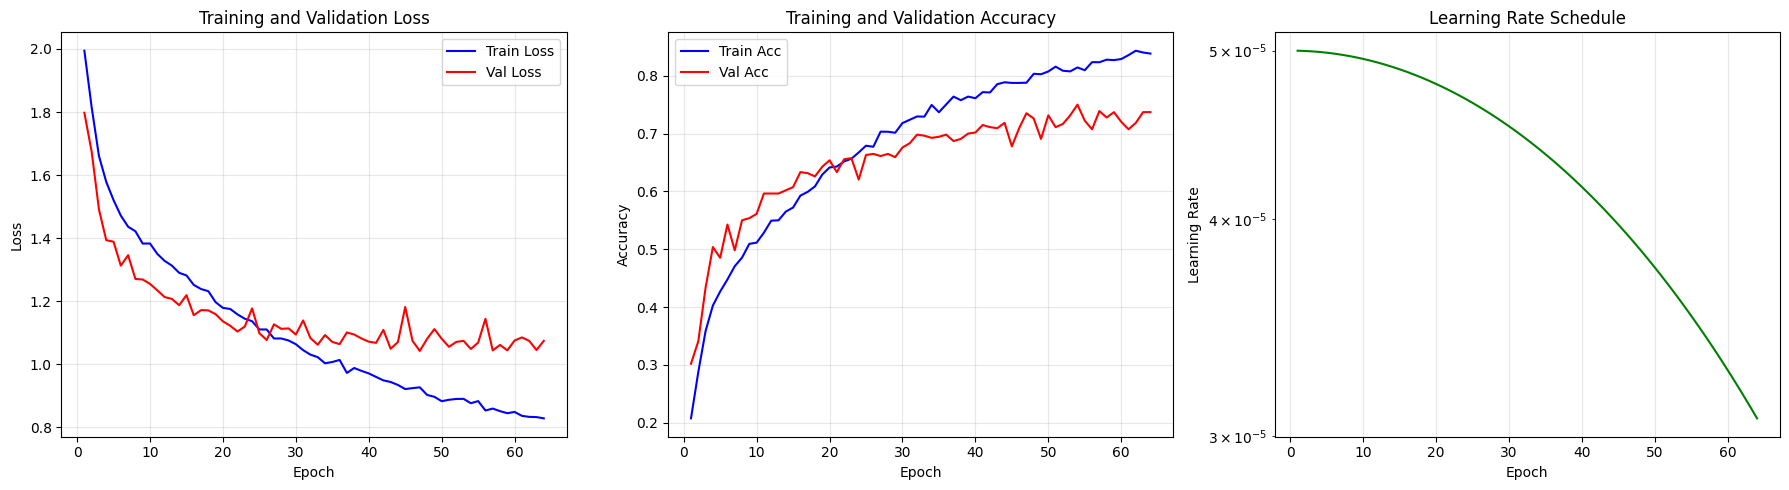


💾 Saving model to MLflow...


2025/11/20 14:09:49 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /local_disk0/repl_tmp_data/ReplId-19a9d-963fb-e/tmphp8g4l98/model/data, flavor: pytorch). Fall back to return ['torch==2.6.0', 'cloudpickle==2.2.1']. Set logging level to DEBUG to see the full traceback. 
2025/11/20 14:09:49 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Uploading artifacts:   0%|          | 0/10 [00:00<?, ?it/s]

✓ Model checkpoint saved to: dbfs:/mnt/playbehavior/Fine_tuning/Processed_Datasets/vit_small_1xval.pth
✓ MLflow artifacts saved to run: e3d202b42d7946298d77dccdabe776aa

✓ VIT-SMALL TRAINING COMPLETE

Final Training Accuracy: 0.8383
Final Validation Accuracy: 0.7370
Best Validation Accuracy: 0.7500

MLflow Run: e3d202b42d7946298d77dccdabe776aa
Model saved: dbfs:/mnt/playbehavior/Fine_tuning/Processed_Datasets/vit_small_1xval.pth


<Figure size 640x480 with 0 Axes>

In [0]:
import time

# Ensure experiment is set
mlflow.set_experiment(TrainingConfig.EXPERIMENT_NAME)
print(f"Using MLflow experiment: {TrainingConfig.EXPERIMENT_NAME}")

# Update configuration for ViT-Small
TrainingConfig.MODEL_NAME = 'vit_small'
TrainingConfig.EPOCHS = 150
TrainingConfig.BATCH_SIZE = 32
TrainingConfig.LEARNING_RATE = 5e-5  # Much smaller for ViT from scratch
TrainingConfig.PATIENCE = 10
TrainingConfig.MIN_DELTA = 0.0005

print("\n" + "="*60)
print("TRAINING VIT-SMALL FROM SCRATCH")
print("="*60)
print(f"Model: {TrainingConfig.MODEL_NAME}")
print(f"Epochs: {TrainingConfig.EPOCHS}")
print(f"Batch size: {TrainingConfig.BATCH_SIZE}")
print(f"Learning rate: {TrainingConfig.LEARNING_RATE}")
print("="*60)

# Create data loaders (reuse from ResNet-18)
print("\nCreating data loaders...")
dataloaders = create_dataloaders(
    train_df=train_split_df,
    val_df=val_split_df,
    test_df=None,
    batch_size=TrainingConfig.BATCH_SIZE,
    num_workers=TrainingConfig.NUM_WORKERS,
    image_size=TrainingConfig.IMAGE_SIZE,
    use_weighted_sampling=TrainingConfig.USE_WEIGHTED_SAMPLING,
    augmentation_strength=TrainingConfig.AUGMENTATION_STRENGTH,
    augmentation_multiplier=TrainingConfig.AUGMENTATION_MULTIPLIER,
    val_augmentation_multiplier=1
)

print(f"✓ Train loader: {len(dataloaders['train'].dataset)} samples")
print(f"✓ Val loader: {len(dataloaders['val'].dataset)} samples")

# Create model
print("\nCreating ViT-Small...")
model = create_model(TrainingConfig.MODEL_NAME, num_classes=TrainingConfig.NUM_CLASSES)
total_params, trainable_params = count_parameters(model)
print(f"✓ Model created")
print(f"  - Total parameters: {total_params:,}")
print(f"  - Trainable parameters: {trainable_params:,}")

# Start MLflow run
print(f"\n{'='*60}")
print("STARTING MLFLOW RUN")
print(f"{'='*60}")

with mlflow.start_run(run_name=f"vit_small_1xval_{int(time.time())}") as run:
    print(f"MLflow Run ID: {run.info.run_id}")
    
    # Log parameters
    mlflow.log_params({
        'model_name': TrainingConfig.MODEL_NAME,
        'num_classes': TrainingConfig.NUM_CLASSES,
        'epochs': TrainingConfig.EPOCHS,
        'batch_size': TrainingConfig.BATCH_SIZE,
        'learning_rate': TrainingConfig.LEARNING_RATE,
        'weight_decay': TrainingConfig.WEIGHT_DECAY,
        'scheduler': TrainingConfig.SCHEDULER_TYPE,
        'augmentation': TrainingConfig.AUGMENTATION_STRENGTH,
        'augmentation_multiplier': TrainingConfig.AUGMENTATION_MULTIPLIER,
        'label_smoothing': TrainingConfig.LABEL_SMOOTHING,
        'image_size': TrainingConfig.IMAGE_SIZE,
        'total_params': total_params,
        'trainable_params': trainable_params,
        'train_samples': len(train_split_df),
        'val_samples': len(val_split_df),
        'effective_train_samples': len(dataloaders['train'].dataset)
    })
    
    # Create trainer
    trainer = Trainer(
        model=model,
        train_loader=dataloaders['train'],
        val_loader=dataloaders['val'],
        config=TrainingConfig
    )
    
    # Train
    history = trainer.train()
    
    # Plot history
    print("\n📊 Plotting training history...")
    plot_training_history(history)
    
    # Save plot to MLflow
    fig_path = "/tmp/vit_training_history.png"
    plt.savefig(fig_path, dpi=150, bbox_inches='tight')
    mlflow.log_artifact(fig_path, "plots")
    
    # Log final metrics
    mlflow.log_metrics({
        'final_train_loss': history['train_loss'][-1],
        'final_train_acc': history['train_acc'][-1],
        'final_val_loss': history['val_loss'][-1],
        'final_val_acc': history['val_acc'][-1],
        'best_val_acc': max(history['val_acc']),
        'total_epochs': len(history['train_loss'])
    })
    
    # Log model
    print("\n💾 Saving model to MLflow...")
    mlflow.pytorch.log_model(model, "model")
    
    # Save final model locally as well
    model_save_path = dbfs_to_local(f"{Config.OUTPUT_BASE}/vit_small_1xval.pth")
    os.makedirs(os.path.dirname(model_save_path), exist_ok=True)
    torch.save({
        'model_state_dict': model.state_dict(),
        'history': history,
        'config': {
            'model_name': TrainingConfig.MODEL_NAME,
            'num_classes': TrainingConfig.NUM_CLASSES,
            'epochs': len(history['train_loss']),
            'final_train_acc': history['train_acc'][-1],
            'final_val_acc': history['val_acc'][-1],
            'best_val_acc': max(history['val_acc'])
        }
    }, model_save_path)
    
    print(f"✓ Model checkpoint saved to: {local_to_dbfs(model_save_path)}")
    print(f"✓ MLflow artifacts saved to run: {run.info.run_id}")

print("\n" + "="*60)
print("✓ VIT-SMALL TRAINING COMPLETE")
print("="*60)
print(f"\nFinal Training Accuracy: {history['train_acc'][-1]:.4f}")
print(f"Final Validation Accuracy: {history['val_acc'][-1]:.4f}")
print(f"Best Validation Accuracy: {max(history['val_acc']):.4f}")
print(f"\nMLflow Run: {run.info.run_id}")
print(f"Model saved: {local_to_dbfs(model_save_path)}")
print("="*60)

## MODULE 12: EVALUATION ON TEST SET

### Vit Small

✓ Libraries imported for comprehensive evaluation
✓ Test dataset class defined

STEP 1: LOAD MODEL FROM MLFLOW
Using MLflow Run ID: e3d202b42d7946298d77dccdabe776aa

Loading model from MLflow...


✓ Model loaded and moved to cuda

Model Info:
  - Model name: vit_small
  - Training samples: 2160
  - Best val acc: 0.7500

STEP 2: SETUP PARALLEL INFERENCE

✓ Using single GPU: Tesla V100-PCIE-16GB

STEP 3: CREATE TEST DATASET

Label mapping (9 classes):
  0: Drinking
  1: Feeding head down
  2: Feeding head up
  3: Lying
  4: Standing
  5: Walking
  6: frontal_pushing
  7: gallop
  8: leap

✓ Test dataset: 211800 samples
✓ Test loader: 3310 batches
✓ Batch size: 64

STEP 4: RUN PARALLEL EVALUATION

Processing 3310 batches with parallel inference...
This will be much faster with multiple GPUs!



Evaluating:  29%|██▉       | 968/3310 [1:17:36<1:39:22,  2.

*** WARNING: max output size exceeded, skipping output. ***

Evaluating: 100%|██████████| 3310/3310 [4:09:35<00:00,  4.52s/it]



✓ Evaluation complete!
  Total time: 14975.5s
  Throughput: 14.1 images/sec
  Time per image: 70.71ms
  Collected 211800 metadata entries

STEP 5: OVERALL TEST SET RESULTS

OVERALL METRICS
Accuracy:  0.6191 (61.91%)
Precision: 0.7417
Recall:    0.6191
F1-Score:  0.6600

STEP 6: DETAILED CLASSIFICATION REPORT

                   precision    recall  f1-score   support

         Drinking     0.2407    0.6201    0.3468      3011
Feeding head down     0.6619    0.3070    0.4194     30952
  Feeding head up     0.4610    0.4327    0.4464     18783
            Lying     0.8916    0.8697    0.8805     83509
         Standing     0.7377    0.5165    0.6076     69807
          Walking     0.0452    0.4703    0.0825      3819
  frontal_pushing     0.5864    0.6617    0.6218       600
           gallop     0.5703    0.6139    0.5913       575
             leap     0.5636    0.5538    0.5586       744

         accuracy                         0.6191    211800
        macro avg     0.5287    0.560

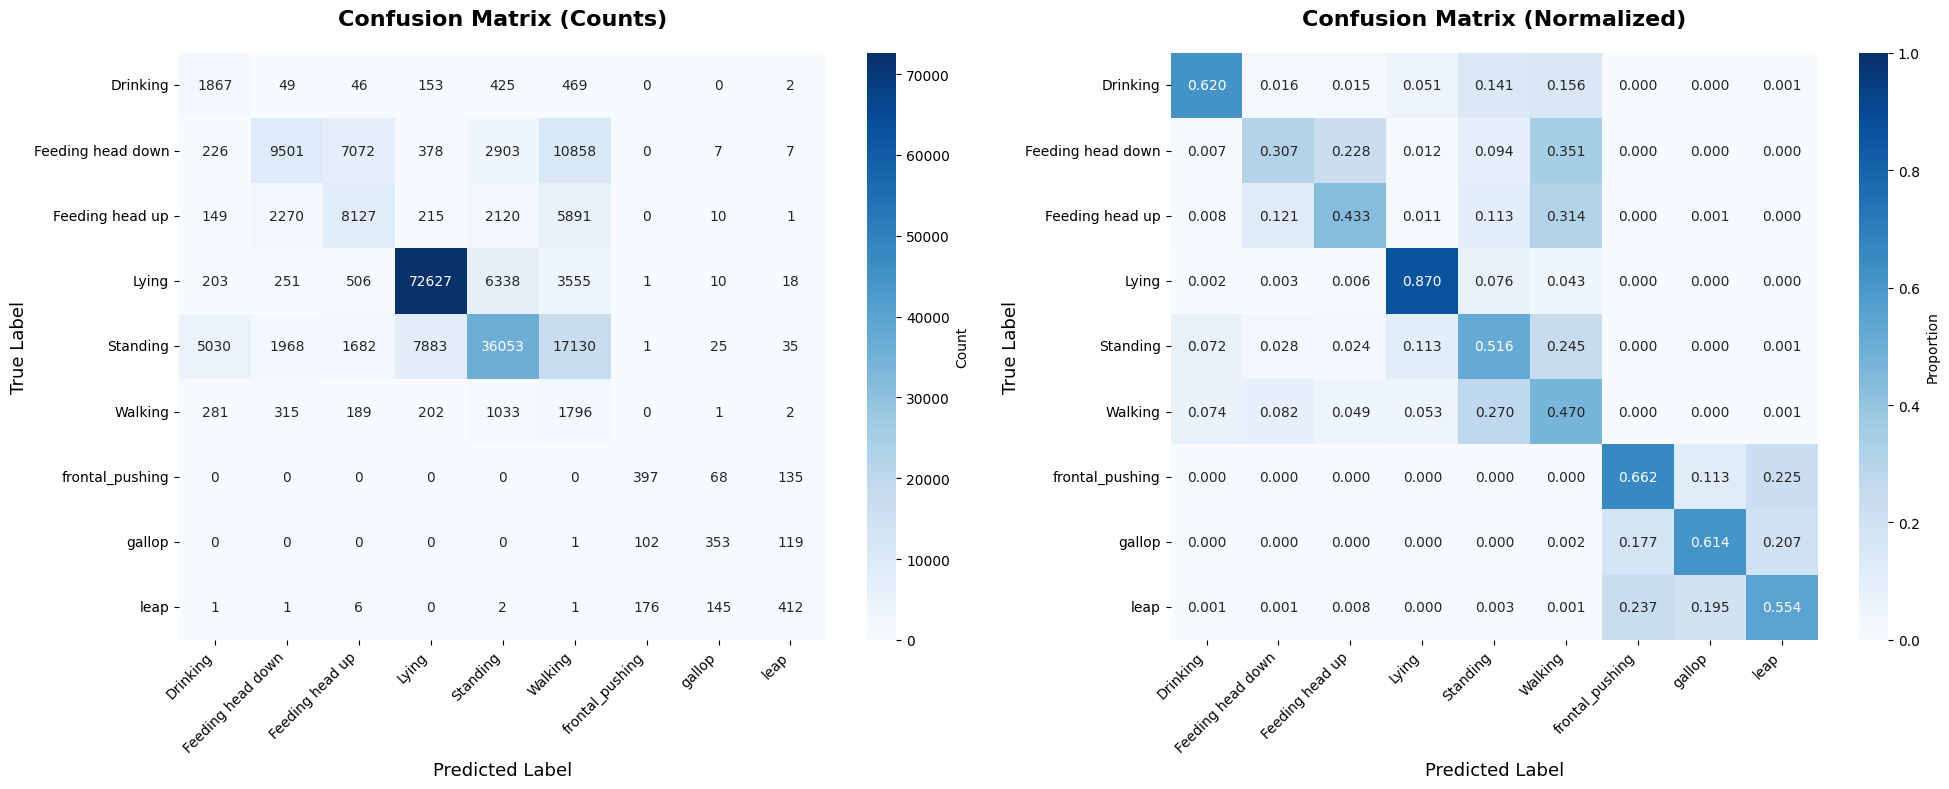


✓ Confusion matrix saved: /tmp/vit_small_confusion_matrix.png

STEP 8: PER-CLASS PERFORMANCE


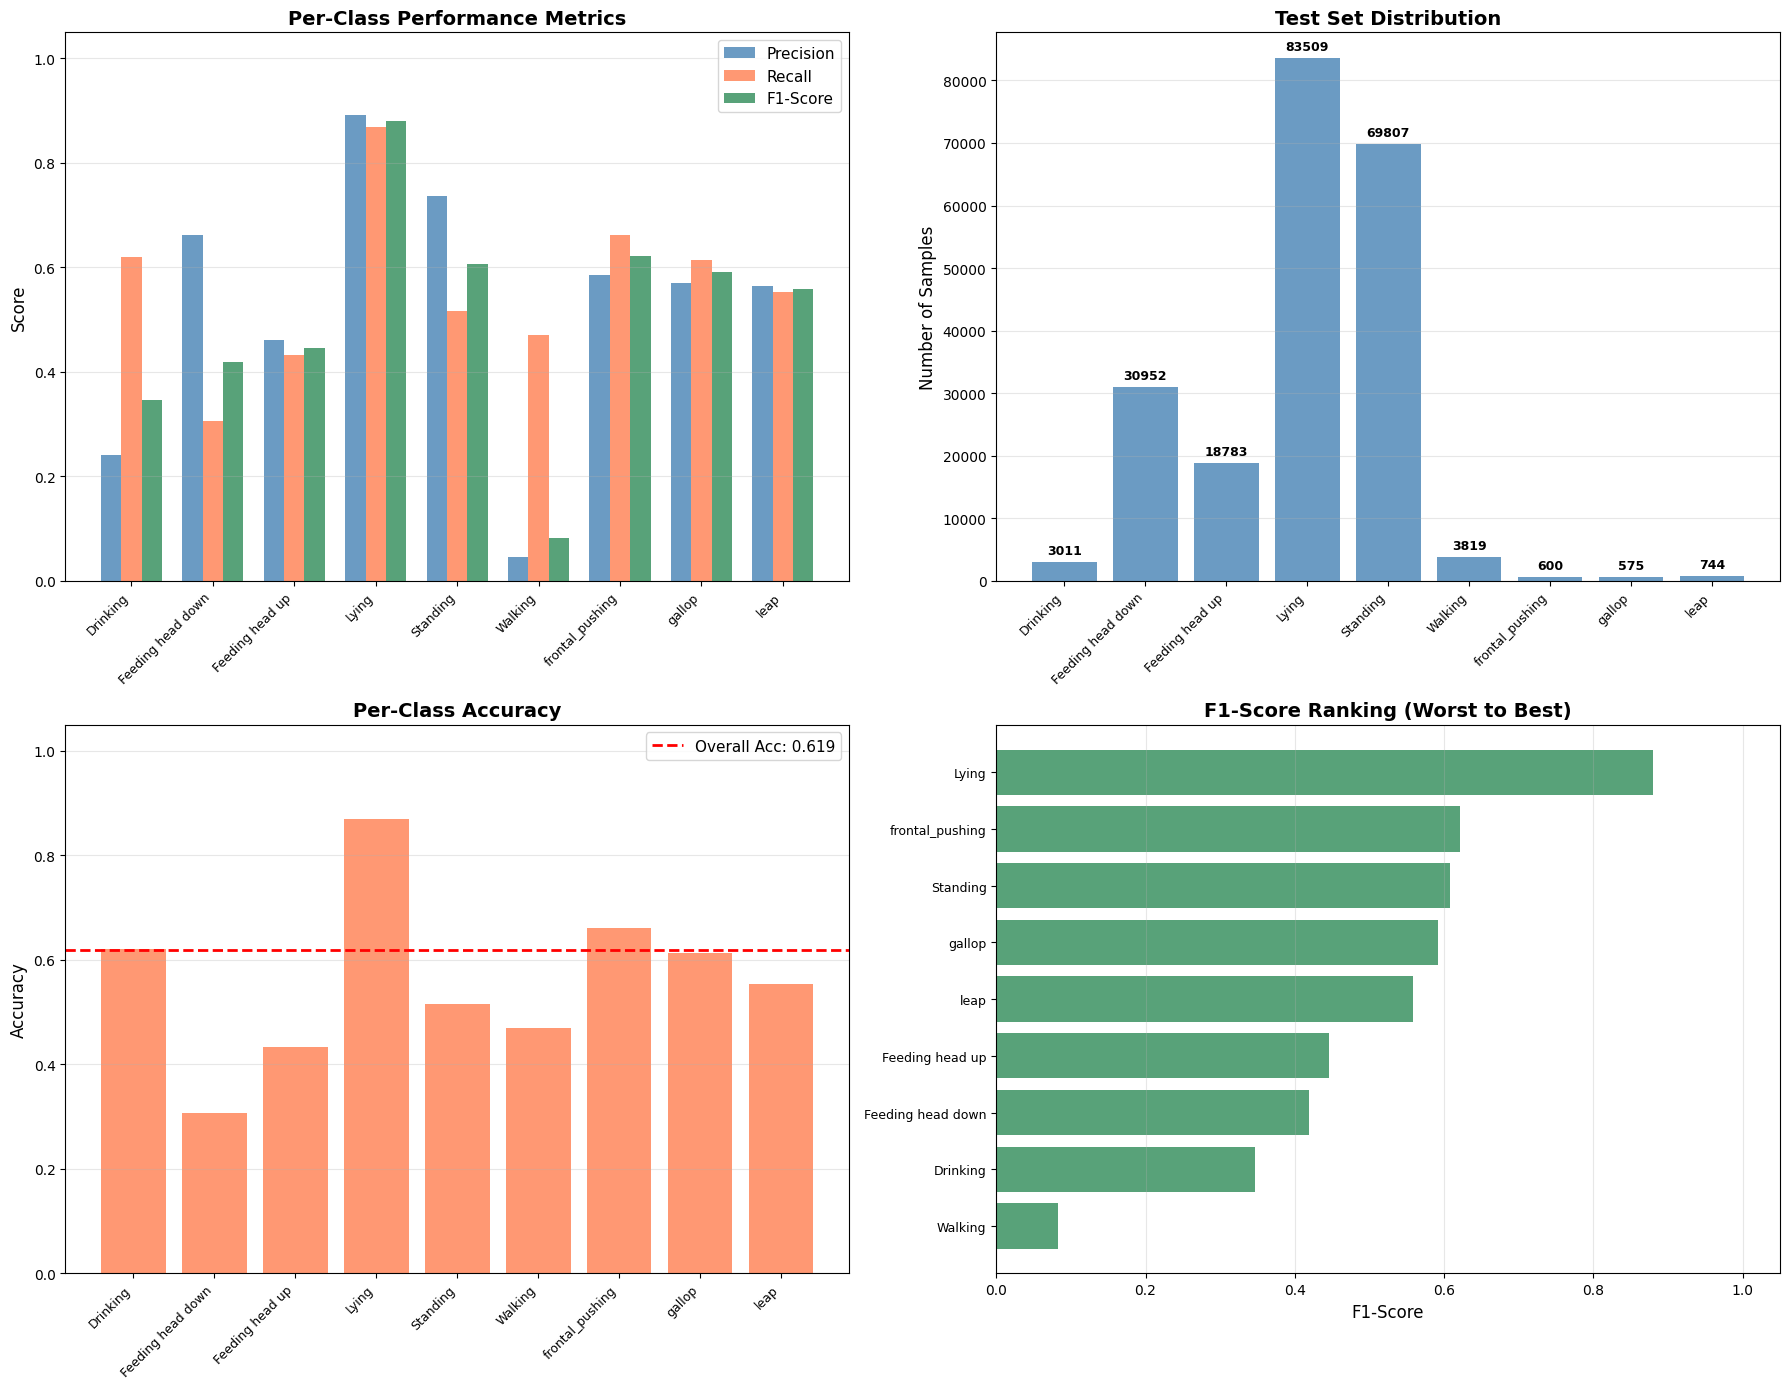

✓ Per-class performance saved: /tmp/vit_small_per_class_performance.png

PER-CLASS DETAILED METRICS
Class                          | Prec     | Recall   | F1       | Acc      | Support
-----------------------------------------------------------------------------------------------
Drinking                       | 0.2407   | 0.6201   | 0.3468   | 0.6201   | 3011
Feeding head down              | 0.6619   | 0.3070   | 0.4194   | 0.3070   | 30952
Feeding head up                | 0.4610   | 0.4327   | 0.4464   | 0.4327   | 18783
Lying                          | 0.8916   | 0.8697   | 0.8805   | 0.8697   | 83509
Standing                       | 0.7377   | 0.5165   | 0.6076   | 0.5165   | 69807
Walking                        | 0.0452   | 0.4703   | 0.0825   | 0.4703   | 3819
frontal_pushing                | 0.5864   | 0.6617   | 0.6218   | 0.6617   | 600
gallop                         | 0.5703   | 0.6139   | 0.5913   | 0.6139   | 575
leap                           | 0.5636   | 0.5538   | 0.5586

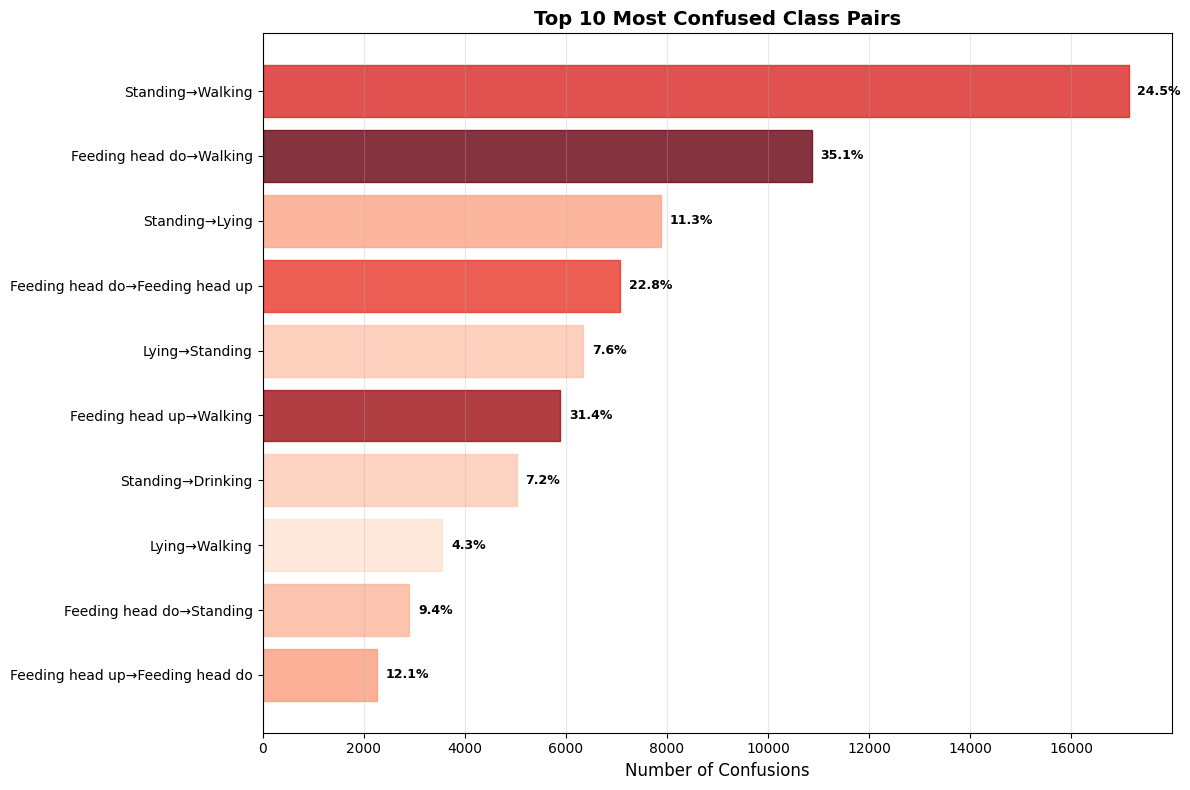


✓ Confusion pairs plot saved: /tmp/vit_small_confusion_pairs.png

STEP 10: PERFORMANCE BY SOURCE

Found 2 source(s): ['mmcows', 'playbehavior']

📊 Performance by Source:
Source               | Samples    | Accuracy   | Precision  | Recall     | F1
------------------------------------------------------------------------------------------
mmcows               | 209881     | 0.6193     | 0.7433     | 0.6193     | 0.6607    
playbehavior         | 1919       | 0.6055     | 0.6106     | 0.6055     | 0.6067    

STEP 11: SAVE RESULTS
✓ Results saved: dbfs:/mnt/playbehavior/Fine_tuning/Processed_Datasets/vit_small_eval_results.json
✓ Predictions saved: dbfs:/mnt/playbehavior/Fine_tuning/Processed_Datasets/vit_small_predictions.csv

STEP 12: LOG TO MLFLOW
✓ All test results logged to MLflow

✅ EVALUATION COMPLETE

Model:                    vit_small
Approach:                 Train from Scratch
MLflow Run:               e3d202b42d7946298d77dccdabe776aa

TEST SET PERFORMANCE
Overall Accuracy:  

---------------------------------------------------------------------------
TypeError                                 Traceback (most recent call last)
File <command-6876243940014665>, line 665
    663 print("\n✅ Best 3 classes (by F1):")
    664 for i, idx in enumerate(best_idx, 1):
--> 665     print(f"  {i}. {target_names[idx]}: F1={f[idx]:.4f}, Acc={class_accuracies[idx]:.4f}")
    667 # Worst 3 classes
    668 worst_idx = np.argsort(f)[:3]

TypeError: '_io.TextIOWrapper' object is not subscriptable

In [0]:
# ============================================================================
# MODULE 12: COMPREHENSIVE EVALUATION ON TEST SET (UNIFIED)
# ============================================================================

import torch
import torch.nn as nn
import torch.nn.functional as F
import random
from torch.utils.data import Dataset, DataLoader
from torchvision import models
from tqdm import tqdm
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import mlflow
import json
import time

# Set random seeds
RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(RANDOM_SEED)

print("✓ Libraries imported for comprehensive evaluation")


# ============================================================================
# SIMPLIFIED DATASET FOR EVALUATION
# ============================================================================

class SimpleTestDataset(Dataset):
    """Simple test dataset without augmentation"""
    
    def __init__(self, df, label_to_idx):
        self.df = df.reset_index(drop=True)
        self.label_to_idx = label_to_idx
        self.idx_to_label = {v: k for k, v in label_to_idx.items()}
        self.num_classes = len(label_to_idx)
        self.transform = AugmentationPipeline(image_size=224, mode='test')
        self._failed = set()
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        if idx in self._failed:
            idx = np.random.randint(0, len(self))
        
        try:
            row = self.df.iloc[idx]
            image = load_image_cv2(row['image_path'])
            
            if image is None:
                self._failed.add(idx)
                return self.__getitem__(np.random.randint(0, len(self)))
            
            label_idx = self.label_to_idx[row['label']]
            image_tensor = self.transform(image)
            
            metadata = {
                'image_path': row['image_path'],
                'label_str': row['label'],
                'source': row.get('source', 'unknown')
            }
            
            return image_tensor, label_idx, metadata
        
        except Exception as e:
            self._failed.add(idx)
            return self.__getitem__(np.random.randint(0, len(self)))


print("✓ Test dataset class defined")


# ============================================================================
# STEP 1: SETUP - DEFINE RUN ID AND LOAD MODEL
# ============================================================================

print("\n" + "="*60)
print("STEP 1: LOAD MODEL FROM MLFLOW")
print("="*60)

# IMPORTANT: REPLACE WITH YOUR ACTUAL RUN_ID
RUN_ID = 'e3d202b42d7946298d77dccdabe776aa'  # ← UPDATE THIS with your actual run ID

print(f"Using MLflow Run ID: {RUN_ID}")

# Load model from MLflow
print("\nLoading model from MLflow...")
model_uri = f'runs:/{RUN_ID}/model'
loaded_model = mlflow.pytorch.load_model(model_uri)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
loaded_model = loaded_model.to(device)
loaded_model.eval()

print(f"✓ Model loaded and moved to {device}")

# Get model info from MLflow
client = mlflow.tracking.MlflowClient()
run = client.get_run(RUN_ID)
run_params = run.data.params
run_metrics = run.data.metrics

print(f"\nModel Info:")
print(f"  - Model name: {run_params.get('model_name', 'unknown')}")
print(f"  - Training samples: {run_params.get('train_samples', 'unknown')}")
print(f"  - Best val acc: {run_metrics.get('best_val_acc', 'unknown'):.4f}")


# ============================================================================
# STEP 2: WRAP WITH DATAPARALLEL FOR MULTI-GPU INFERENCE
# ============================================================================

print("\n" + "="*60)
print("STEP 2: SETUP PARALLEL INFERENCE")
print("="*60)

num_gpus = torch.cuda.device_count()

if num_gpus > 1:
    print(f"\n✓ Detected {num_gpus} GPUs - enabling DataParallel")
    print(f"  GPUs: {[torch.cuda.get_device_name(i) for i in range(num_gpus)]}")
    
    # Wrap model with DataParallel
    loaded_model = nn.DataParallel(loaded_model)
    
    print(f"✓ Model will use all {num_gpus} GPUs for parallel inference")
    print(f"  Effective batch size per forward pass: {64 * num_gpus}")
else:
    print(f"\n✓ Using single GPU: {torch.cuda.get_device_name(0)}")

loaded_model = loaded_model.to('cuda')
loaded_model.eval()


# ============================================================================
# STEP 3: CREATE TEST DATASET
# ============================================================================

print("\n" + "="*60)
print("STEP 3: CREATE TEST DATASET")
print("="*60)

# Create label mapping
all_labels = sorted(Config.ALL_LABELS)
label_to_idx = {label: idx for idx, label in enumerate(all_labels)}
idx_to_label = {v: k for k, v in label_to_idx.items()}

print(f"\nLabel mapping ({len(label_to_idx)} classes):")
for label, idx in sorted(label_to_idx.items(), key=lambda x: x[1]):
    print(f"  {idx}: {label}")

# Create test dataset
test_dataset = SimpleTestDataset(combined_test_df, label_to_idx)

# Adjust batch size based on number of GPUs
test_batch_size = 64 if num_gpus <= 1 else 64 * num_gpus

test_loader = DataLoader(
    test_dataset,
    batch_size=test_batch_size,
    shuffle=False,
    num_workers=8,
    pin_memory=True,
    drop_last=False
)

print(f"\n✓ Test dataset: {len(test_dataset)} samples")
print(f"✓ Test loader: {len(test_loader)} batches")
print(f"✓ Batch size: {test_batch_size}")


# ============================================================================
# STEP 4: RUN PARALLEL EVALUATION (FIXED)
# ============================================================================

print("\n" + "="*60)
print("STEP 4: RUN PARALLEL EVALUATION")
print("="*60)

all_preds = []
all_labels_list = []
all_metadata = []

print(f"\nProcessing {len(test_loader)} batches with parallel inference...")
print("This will be much faster with multiple GPUs!\n")

start_time = time.time()

loaded_model.eval()

with torch.no_grad():
    for images, labels, metadata_batch in tqdm(test_loader, desc="Evaluating"):
        images = images.to('cuda', non_blocking=True)
        
        # Forward pass with automatic mixed precision
        with torch.cuda.amp.autocast():
            logits = loaded_model(images)
        
        preds = logits.argmax(dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels_list.extend(labels.numpy())
        
        # FIXED: Properly handle metadata batch
        # metadata_batch is a dict of lists (batch_size elements per key)
        batch_size = len(labels)
        for i in range(batch_size):
            # Extract metadata for each sample in the batch
            sample_metadata = {
                'image_path': metadata_batch['image_path'][i],
                'label_str': metadata_batch['label_str'][i],
                'source': metadata_batch['source'][i]
            }
            all_metadata.append(sample_metadata)

eval_time = time.time() - start_time

print(f"\n✓ Evaluation complete!")
print(f"  Total time: {eval_time:.1f}s")
print(f"  Throughput: {len(test_dataset) / eval_time:.1f} images/sec")
print(f"  Time per image: {eval_time / len(test_dataset) * 1000:.2f}ms")
print(f"  Collected {len(all_metadata)} metadata entries")


# ============================================================================
# STEP 5: CALCULATE OVERALL METRICS
# ============================================================================

print("\n" + "="*60)
print("STEP 5: OVERALL TEST SET RESULTS")
print("="*60)

accuracy = accuracy_score(all_labels_list, all_preds)
precision, recall, f1, support = precision_recall_fscore_support(
    all_labels_list, all_preds, average='weighted'
)

print(f"\n{'='*60}")
print("OVERALL METRICS")
print(f"{'='*60}")
print(f"Accuracy:  {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")
print(f"{'='*60}")


# ============================================================================
# STEP 6: DETAILED CLASSIFICATION REPORT
# ============================================================================

print("\n" + "="*60)
print("STEP 6: DETAILED CLASSIFICATION REPORT")
print("="*60 + "\n")

target_names = [idx_to_label[i] for i in range(len(label_to_idx))]
print(classification_report(all_labels_list, all_preds, 
                          target_names=target_names, 
                          digits=4))


# ============================================================================
# STEP 7: CONFUSION MATRICES (COUNTS + NORMALIZED)
# ============================================================================

print("\n" + "="*60)
print("STEP 7: CONFUSION MATRICES")
print("="*60)

cm = confusion_matrix(all_labels_list, all_preds)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Confusion matrix - Counts
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_names, yticklabels=target_names, ax=axes[0],
            cbar_kws={'label': 'Count'}, annot_kws={'size': 10})
axes[0].set_title('Confusion Matrix (Counts)', fontsize=16, fontweight='bold', pad=20)
axes[0].set_ylabel('True Label', fontsize=13)
axes[0].set_xlabel('Predicted Label', fontsize=13)
plt.setp(axes[0].get_xticklabels(), rotation=45, ha='right', fontsize=10)
plt.setp(axes[0].get_yticklabels(), rotation=0, fontsize=10)

# Confusion matrix - Normalized
sns.heatmap(cm_norm, annot=True, fmt='.3f', cmap='Blues',
            xticklabels=target_names, yticklabels=target_names, ax=axes[1],
            cbar_kws={'label': 'Proportion'}, vmin=0, vmax=1, annot_kws={'size': 10})
axes[1].set_title('Confusion Matrix (Normalized)', fontsize=16, fontweight='bold', pad=20)
axes[1].set_ylabel('True Label', fontsize=13)
axes[1].set_xlabel('Predicted Label', fontsize=13)
plt.setp(axes[1].get_xticklabels(), rotation=45, ha='right', fontsize=10)
plt.setp(axes[1].get_yticklabels(), rotation=0, fontsize=10)

plt.tight_layout()
cm_save_path = f'/tmp/{run_params.get("model_name", "model")}_confusion_matrix.png'
plt.savefig(cm_save_path, dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✓ Confusion matrix saved: {cm_save_path}")


# ============================================================================
# STEP 8: PER-CLASS PERFORMANCE ANALYSIS
# ============================================================================

print("\n" + "="*60)
print("STEP 8: PER-CLASS PERFORMANCE")
print("="*60)

p, r, f, s = precision_recall_fscore_support(all_labels_list, all_preds, average=None)

# Create comprehensive per-class plots
fig, axes = plt.subplots(2, 2, figsize=(18, 14))
x = np.arange(len(target_names))
width = 0.25

# [1] Metrics Bar Chart
axes[0, 0].bar(x - width, p, width, label='Precision', alpha=0.8, color='steelblue')
axes[0, 0].bar(x, r, width, label='Recall', alpha=0.8, color='coral')
axes[0, 0].bar(x + width, f, width, label='F1-Score', alpha=0.8, color='seagreen')
axes[0, 0].set_ylabel('Score', fontsize=12)
axes[0, 0].set_title('Per-Class Performance Metrics', fontsize=14, fontweight='bold')
axes[0, 0].set_xticks(x)
axes[0, 0].set_xticklabels(target_names, rotation=45, ha='right', fontsize=9)
axes[0, 0].legend(fontsize=11)
axes[0, 0].set_ylim(0, 1.05)
axes[0, 0].grid(axis='y', alpha=0.3)

# [2] Test Set Distribution
axes[0, 1].bar(x, s, alpha=0.8, color='steelblue')
axes[0, 1].set_ylabel('Number of Samples', fontsize=12)
axes[0, 1].set_title('Test Set Distribution', fontsize=14, fontweight='bold')
axes[0, 1].set_xticks(x)
axes[0, 1].set_xticklabels(target_names, rotation=45, ha='right', fontsize=9)
axes[0, 1].grid(axis='y', alpha=0.3)

for i, v in enumerate(s):
    axes[0, 1].text(i, v + max(s)*0.01, str(int(v)), 
                    ha='center', va='bottom', fontsize=9, fontweight='bold')

# [3] Per-Class Accuracy
class_accuracies = []
for i in range(len(cm)):
    class_acc = cm[i, i] / cm[i].sum() if cm[i].sum() > 0 else 0
    class_accuracies.append(class_acc)

axes[1, 0].bar(x, class_accuracies, alpha=0.8, color='coral')
axes[1, 0].set_ylabel('Accuracy', fontsize=12)
axes[1, 0].set_title('Per-Class Accuracy', fontsize=14, fontweight='bold')
axes[1, 0].set_xticks(x)
axes[1, 0].set_xticklabels(target_names, rotation=45, ha='right', fontsize=9)
axes[1, 0].set_ylim(0, 1.05)
axes[1, 0].axhline(y=accuracy, color='red', linestyle='--', 
                    label=f'Overall Acc: {accuracy:.3f}', linewidth=2)
axes[1, 0].legend(fontsize=11)
axes[1, 0].grid(axis='y', alpha=0.3)

# [4] F1-Score Ranking
f1_sorted_idx = np.argsort(f)
axes[1, 1].barh(np.arange(len(f1_sorted_idx)), f[f1_sorted_idx], alpha=0.8, color='seagreen')
axes[1, 1].set_yticks(np.arange(len(f1_sorted_idx)))
axes[1, 1].set_yticklabels([target_names[i] for i in f1_sorted_idx], fontsize=9)
axes[1, 1].set_xlabel('F1-Score', fontsize=12)
axes[1, 1].set_title('F1-Score Ranking (Worst to Best)', fontsize=14, fontweight='bold')
axes[1, 1].set_xlim(0, 1.05)
axes[1, 1].grid(axis='x', alpha=0.3)

plt.tight_layout()
perf_save_path = f'/tmp/{run_params.get("model_name", "model")}_per_class_performance.png'
plt.savefig(perf_save_path, dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ Per-class performance saved: {perf_save_path}")


# Print detailed per-class table
print("\n" + "="*60)
print("PER-CLASS DETAILED METRICS")
print("="*60)
print(f"{'Class':<30s} | {'Prec':<8s} | {'Recall':<8s} | {'F1':<8s} | {'Acc':<8s} | {'Support'}")
print("-" * 95)

for i in range(len(target_names)):
    print(f"{target_names[i]:<30s} | {p[i]:<8.4f} | {r[i]:<8.4f} | {f[i]:<8.4f} | "
          f"{class_accuracies[i]:<8.4f} | {int(s[i])}")


# ============================================================================
# STEP 9: CONFUSION PAIR ANALYSIS
# ============================================================================

print("\n" + "="*60)
print("STEP 9: CONFUSION PAIR ANALYSIS")
print("="*60)

# Find most confused pairs
pairs = []
for i in range(len(cm)):
    for j in range(len(cm)):
        if i != j and cm[i, j] > 0:
            pairs.append({
                'true': target_names[i],
                'pred': target_names[j],
                'count': cm[i, j],
                'pct': cm[i, j] / cm[i].sum() * 100,
                'true_idx': i,
                'pred_idx': j
            })

pairs.sort(key=lambda x: x['count'], reverse=True)

print("\n📊 Top 15 Most Confused Pairs:")
print(f"{'True Label':<30s} | {'Predicted As':<30s} | {'Count':<8s} | {'% of True'}")
print("-" * 100)

for pair in pairs[:15]:
    print(f"{pair['true']:<30s} | {pair['pred']:<30s} | {pair['count']:<8d} | {pair['pct']:>7.2f}%")


# Visualize top confusion pairs
top_n_pairs = 10
if len(pairs) >= top_n_pairs:
    fig, ax = plt.subplots(figsize=(12, 8))
    
    top_pairs = pairs[:top_n_pairs]
    labels = [f"{p['true'][:15]}→{p['pred'][:15]}" for p in top_pairs]
    counts = [p['count'] for p in top_pairs]
    pcts = [p['pct'] for p in top_pairs]
    
    y_pos = np.arange(len(labels))
    bars = ax.barh(y_pos, counts, alpha=0.8, color='coral')
    
    # Color bars by percentage
    colors = plt.cm.Reds(np.array(pcts) / max(pcts))
    for bar, color in zip(bars, colors):
        bar.set_color(color)
    
    ax.set_yticks(y_pos)
    ax.set_yticklabels(labels, fontsize=10)
    ax.invert_yaxis()
    ax.set_xlabel('Number of Confusions', fontsize=12)
    ax.set_title(f'Top {top_n_pairs} Most Confused Class Pairs', 
                 fontsize=14, fontweight='bold')
    ax.grid(axis='x', alpha=0.3)
    
    # Add percentage labels
    for i, (count, pct) in enumerate(zip(counts, pcts)):
        ax.text(count + max(counts)*0.01, i, f'{pct:.1f}%', 
                va='center', fontsize=9, fontweight='bold')
    
    plt.tight_layout()
    confusion_pairs_path = f'/tmp/{run_params.get("model_name", "model")}_confusion_pairs.png'
    plt.savefig(confusion_pairs_path, dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"\n✓ Confusion pairs plot saved: {confusion_pairs_path}")


# ============================================================================
# STEP 10: PERFORMANCE BY SOURCE (MMcows vs PlayBehavior)
# ============================================================================

print("\n" + "="*60)
print("STEP 10: PERFORMANCE BY SOURCE")
print("="*60)

# Extract source from metadata (now correctly formatted)
sources = [m['source'] for m in all_metadata]
unique_sources = sorted(set(sources))

print(f"\nFound {len(unique_sources)} source(s): {unique_sources}")

# Calculate metrics per source
source_metrics = {}

for source in unique_sources:
    source_mask = [s == source for s in sources]
    source_labels = [l for l, m in zip(all_labels_list, source_mask) if m]
    source_preds = [p for p, m in zip(all_preds, source_mask) if m]
    
    if len(source_labels) > 0:
        source_acc = accuracy_score(source_labels, source_preds)
        source_p, source_r, source_f, _ = precision_recall_fscore_support(
            source_labels, source_preds, average='weighted', zero_division=0
        )
        
        source_metrics[source] = {
            'accuracy': source_acc,
            'precision': source_p,
            'recall': source_r,
            'f1': source_f,
            'samples': len(source_labels)
        }

print("\n📊 Performance by Source:")
print(f"{'Source':<20s} | {'Samples':<10s} | {'Accuracy':<10s} | {'Precision':<10s} | {'Recall':<10s} | {'F1'}")
print("-" * 90)

for source, metrics in source_metrics.items():
    print(f"{source:<20s} | {metrics['samples']:<10d} | {metrics['accuracy']:<10.4f} | "
          f"{metrics['precision']:<10.4f} | {metrics['recall']:<10.4f} | {metrics['f1']:<10.4f}")


# ============================================================================
# STEP 11: SAVE COMPREHENSIVE RESULTS
# ============================================================================

print("\n" + "="*60)
print("STEP 11: SAVE RESULTS")
print("="*60)

# Create comprehensive results dictionary
results = {
    'model': run_params.get('model_name', 'unknown'),
    'approach': 'train_from_scratch',
    'source': 'mlflow',
    'run_id': RUN_ID,
    'training_config': dict(run_params),
    
    # Overall metrics
    'overall': {
        'accuracy': float(accuracy),
        'precision': float(precision),
        'recall': float(recall),
        'f1': float(f1),
        'test_samples': len(all_labels_list),
        'inference_time_sec': float(eval_time),
        'throughput_imgs_per_sec': float(len(test_dataset) / eval_time)
    },
    
    # Per-class metrics
    'per_class': {},
    
    # Per-source metrics
    'per_source': source_metrics,
    
    # Confusion pairs
    'top_confused_pairs': [
        {
            'true_label': pair['true'],
            'predicted_label': pair['pred'],
            'count': int(pair['count']),
            'percentage': float(pair['pct'])
        }
        for pair in pairs[:20]
    ],
    
    # Confusion matrix
    'confusion_matrix': cm.tolist(),
    'confusion_matrix_normalized': cm_norm.tolist()
}

# Add per-class details
for i, label in enumerate(target_names):
    results['per_class'][label] = {
        'precision': float(p[i]),
        'recall': float(r[i]),
        'f1': float(f[i]),
        'accuracy': float(class_accuracies[i]),
        'support': int(s[i])
    }

# Save to JSON
model_name = run_params.get('model_name', 'model')
results_path = dbfs_to_local(f"{Config.OUTPUT_BASE}/{model_name}_eval_results.json")
os.makedirs(os.path.dirname(results_path), exist_ok=True)

with open(results_path, 'w') as f:
    json.dump(results, f, indent=2)

print(f"✓ Results saved: {local_to_dbfs(results_path)}")


# Save predictions to CSV
predictions_df = pd.DataFrame({
    'image_path': [m['image_path'] for m in all_metadata],
    'true_label': [idx_to_label[l] for l in all_labels_list],
    'predicted_label': [idx_to_label[p] for p in all_preds],
    'correct': [l == p for l, p in zip(all_labels_list, all_preds)],
    'source': [m['source'] for m in all_metadata]
})

predictions_csv_path = dbfs_to_local(f"{Config.OUTPUT_BASE}/{model_name}_predictions.csv")
predictions_df.to_csv(predictions_csv_path, index=False)

print(f"✓ Predictions saved: {local_to_dbfs(predictions_csv_path)}")


# ============================================================================
# STEP 12: LOG TO MLFLOW
# ============================================================================

print("\n" + "="*60)
print("STEP 12: LOG TO MLFLOW")
print("="*60)

with mlflow.start_run(run_id=RUN_ID):
    # Log test metrics
    mlflow.log_metrics({
        'test_accuracy': accuracy,
        'test_precision': precision,
        'test_recall': recall,
        'test_f1': f1,
        'test_samples': len(all_labels_list),
        'inference_time_sec': eval_time,
        'throughput_imgs_per_sec': len(test_dataset) / eval_time
    })
    
    # Log per-source metrics
    for source, metrics in source_metrics.items():
        mlflow.log_metrics({
            f'test_{source}_accuracy': metrics['accuracy'],
            f'test_{source}_f1': metrics['f1'],
            f'test_{source}_samples': metrics['samples']
        })
    
    # Log plots
    mlflow.log_artifact(cm_save_path, "test_results")
    mlflow.log_artifact(perf_save_path, "test_results")
    if len(pairs) >= 10:
        mlflow.log_artifact(confusion_pairs_path, "test_results")
    
    # Log results files
    mlflow.log_artifact(results_path, "test_results")
    mlflow.log_artifact(predictions_csv_path, "test_results")
    
    print("✓ All test results logged to MLflow")


# ============================================================================
# FINAL SUMMARY
# ============================================================================

print("\n" + "="*60)
print("✅ EVALUATION COMPLETE")
print("="*60)

print(f"\n{'Model:':<25s} {run_params.get('model_name', 'unknown')}")
print(f"{'Approach:':<25s} Train from Scratch")
print(f"{'MLflow Run:':<25s} {RUN_ID}")

print(f"\n{'='*60}")
print("TEST SET PERFORMANCE")
print(f"{'='*60}")
print(f"{'Overall Accuracy:':<25s} {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"{'Overall F1-Score:':<25s} {f1:.4f}")
print(f"{'Test Samples:':<25s} {len(all_labels_list):,}")
print(f"{'Inference Time:':<25s} {eval_time:.1f}s")
print(f"{'Throughput:':<25s} {len(test_dataset) / eval_time:.1f} images/sec")

print(f"\n{'='*60}")
print("BEST/WORST PERFORMING CLASSES")
print(f"{'='*60}")

# Best 3 classes
best_idx = np.argsort(f)[-3:][::-1]
print("\n✅ Best 3 classes (by F1):")
for i, idx in enumerate(best_idx, 1):
    print(f"  {i}. {target_names[idx]}: F1={f[idx]:.4f}, Acc={class_accuracies[idx]:.4f}")

# Worst 3 classes
worst_idx = np.argsort(f)[:3]
print("\n⚠️  Worst 3 classes (by F1):")
for i, idx in enumerate(worst_idx, 1):
    print(f"  {i}. {target_names[idx]}: F1={f[idx]:.4f}, Acc={class_accuracies[idx]:.4f}")

print(f"\n{'='*60}")
print("PERFORMANCE BY SOURCE")
print(f"{'='*60}")
for source, metrics in source_metrics.items():
    print(f"\n{source}:")
    print(f"  Samples: {metrics['samples']:,}")
    print(f"  Accuracy: {metrics['accuracy']:.4f}")
    print(f"  F1-Score: {metrics['f1']:.4f}")

print(f"\n{'='*60}")
print("SAVED FILES")
print(f"{'='*60}")
print(f"  Results JSON: {local_to_dbfs(results_path)}")
print(f"  Predictions CSV: {local_to_dbfs(predictions_csv_path)}")
print(f"  Confusion matrix: {cm_save_path}")
print(f"  Per-class metrics: {perf_save_path}")
if len(pairs) >= 10:
    print(f"  Confusion pairs: {confusion_pairs_path}")

print(f"\n{'='*60}")
print("COMPARISON SUMMARY")
print(f"{'='*60}")
print("\nNow you can compare across all 3 approaches:")
print("  1. Train from Scratch (ResNet-18/ViT-Small)")
print("  2. Frozen DINOv3 + Classifier")
print("  3. Fine-tuned approaches (QLoRA, VPTDeep, etc.)")
print("\nAll approaches now have identical evaluation metrics!")

print("\n" + "="*60)
print("🎉 ALL DONE!")
print("="*60)

### Resnet - 18

✓ Libraries imported for comprehensive evaluation
✓ Test dataset class defined

STEP 1: LOAD MODEL FROM MLFLOW
Using MLflow Run ID: 0e9d0cc98c094c36ad4e67ce32a351f1

Loading model from MLflow...


/databricks/python/lib/python3.12/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 6, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


✓ Model loaded and moved to cuda

Model Info:
  - Model name: resnet18
  - Training samples: 2160
  - Best val acc: 0.8093
  - Available metrics: ['learning_rate', 'train_acc', 'train_loss', 'val_acc', 'val_loss']

STEP 2: SETUP PARALLEL INFERENCE

✓ Using single GPU: Tesla V100-PCIE-16GB

STEP 3: CREATE TEST DATASET

Label mapping (9 classes):
  0: Drinking
  1: Feeding head down
  2: Feeding head up
  3: Lying
  4: Standing
  5: Walking
  6: frontal_pushing
  7: gallop
  8: leap

✓ Test dataset: 211800 samples
✓ Test loader: 3310 batches
✓ Batch size: 64

STEP 4: RUN PARALLEL EVALUATION

Processing 3310 batches with parallel inference...
This will be much faster with multiple GPUs!



Evaluating:   0%|          | 0/3310 [00:00<?, ?it/s]/root/.ipykernel/1097/command-6876243940014666-3088048878:223: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Evaluating:   1%|          | 23/3310 [02:14<3:35:04,  3.93s/it]/root/.ipykernel/1097/command-6876243940014666-3088048878:223: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Evaluating

*** WARNING: max output size exceeded, skipping output. ***

Evaluating: 100%|██████████| 3310/3310 [4:28:44<00:00,  4.87s/it]



✓ Evaluation complete!
  Total time: 16124.9s
  Throughput: 13.1 images/sec
  Time per image: 76.13ms
  Collected 211800 metadata entries

STEP 5: OVERALL TEST SET RESULTS

OVERALL METRICS
Accuracy:  0.7287 (72.87%)
Precision: 0.8158
Recall:    0.7287
F1-Score:  0.7526

STEP 6: DETAILED CLASSIFICATION REPORT

                   precision    recall  f1-score   support

         Drinking     0.3533    0.6921    0.4678      3011
Feeding head down     0.8161    0.3525    0.4924     30952
  Feeding head up     0.6012    0.4255    0.4983     18783
            Lying     0.9401    0.9790    0.9592     83509
         Standing     0.7944    0.6981    0.7432     69807
          Walking     0.0594    0.4436    0.1048      3819
  frontal_pushing     0.4658    0.9067    0.6154       600
           gallop     0.4250    0.5670    0.4858       575
             leap     0.6032    0.4005    0.4814       744

         accuracy                         0.7287    211800
        macro avg     0.5621    0.607

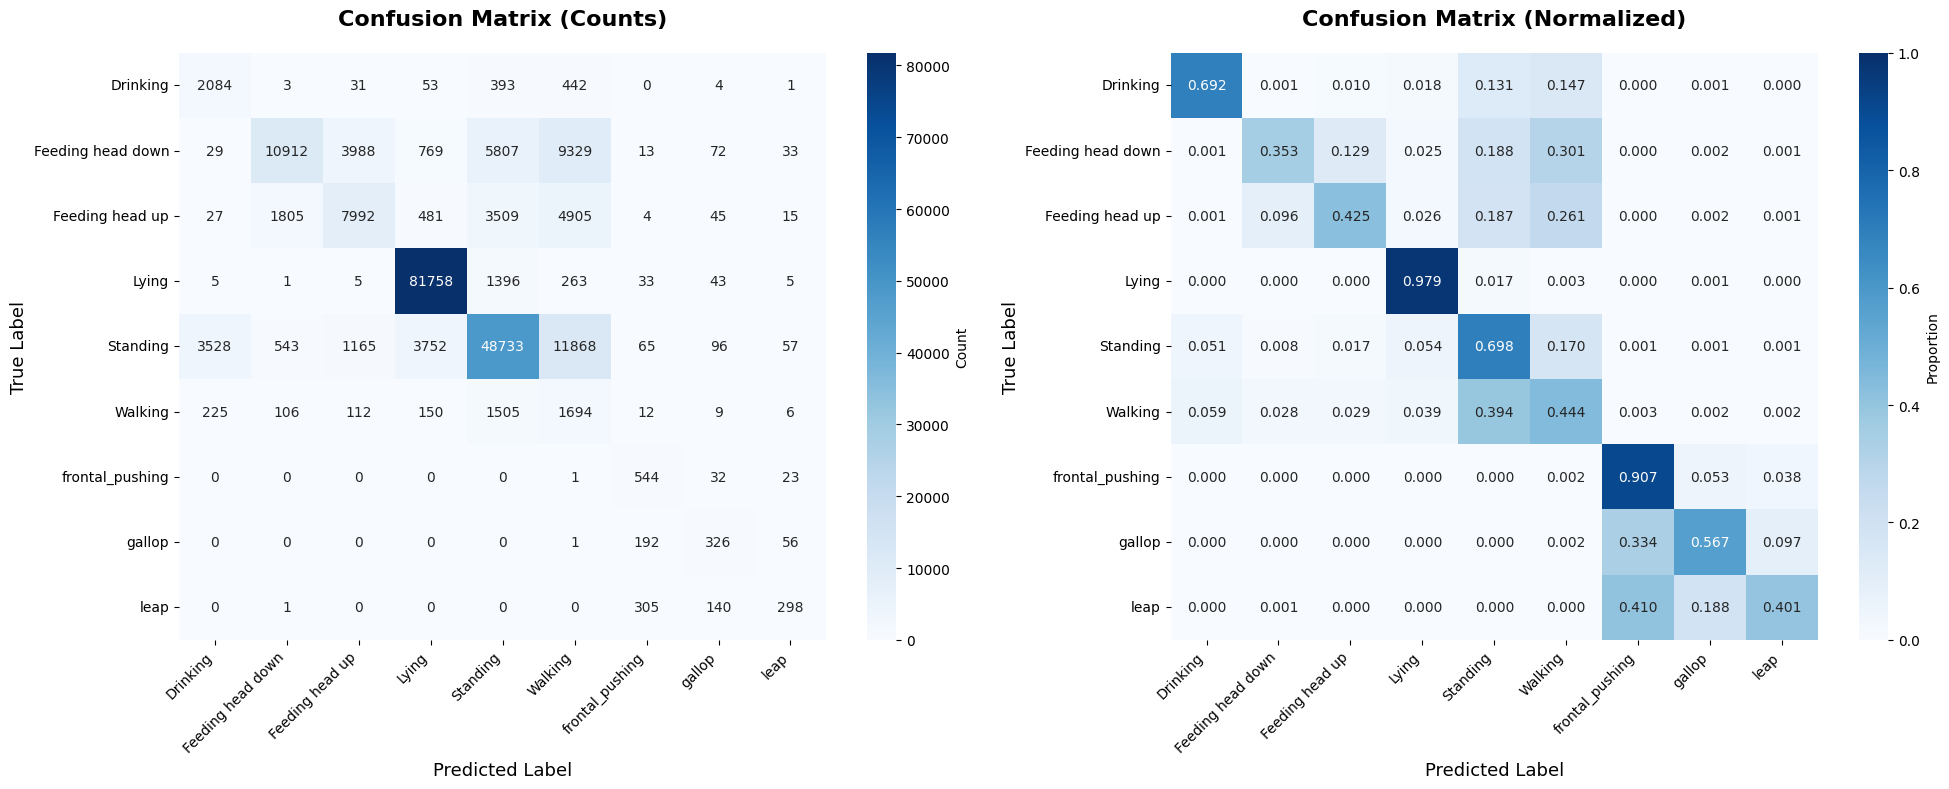


✓ Confusion matrix saved: /tmp/resnet18_confusion_matrix.png

STEP 8: PER-CLASS PERFORMANCE


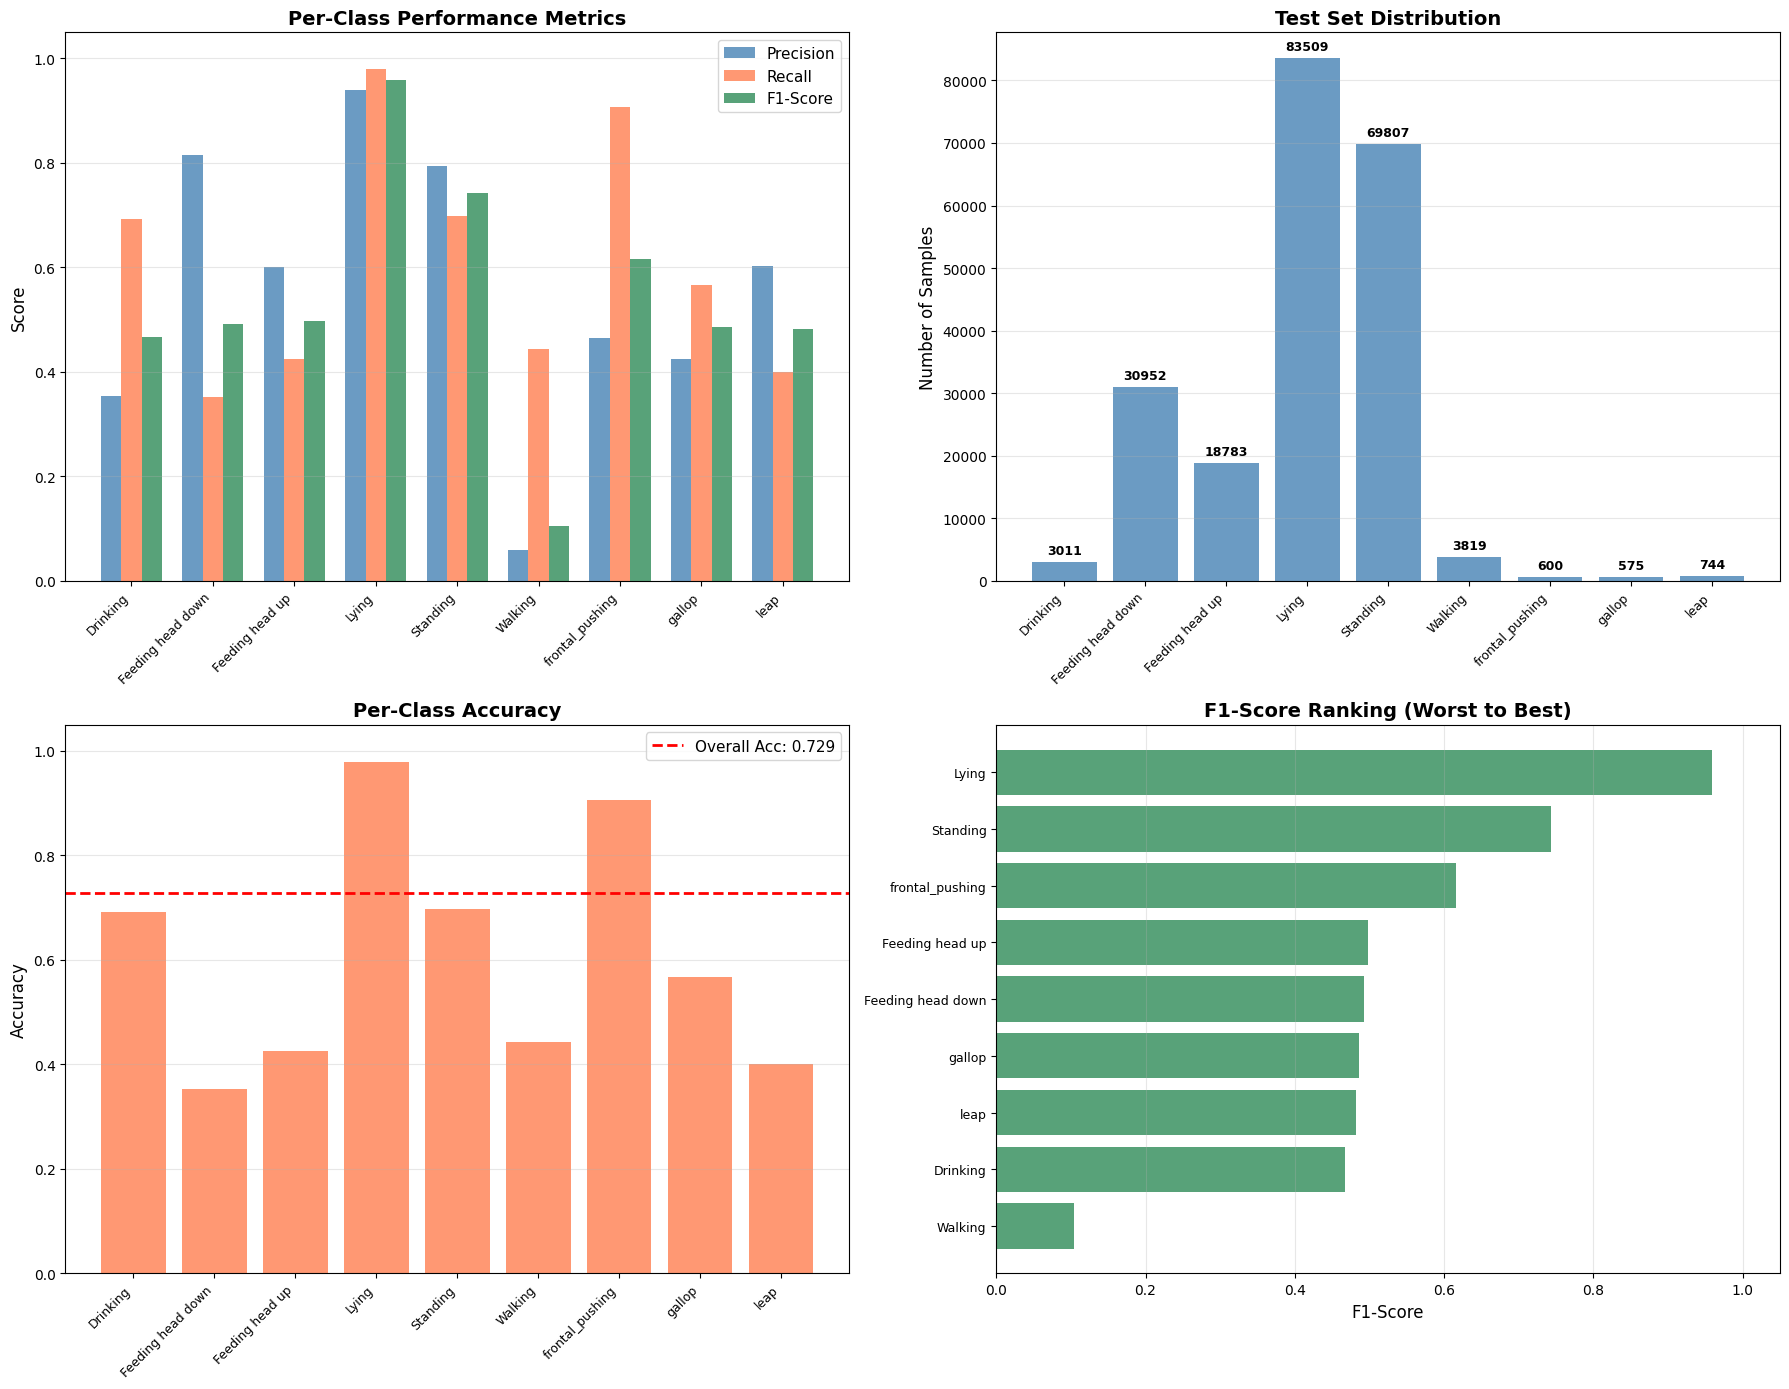

✓ Per-class performance saved: /tmp/resnet18_per_class_performance.png

PER-CLASS DETAILED METRICS
Class                          | Prec     | Recall   | F1       | Acc      | Support
-----------------------------------------------------------------------------------------------
Drinking                       | 0.3533   | 0.6921   | 0.4678   | 0.6921   | 3011
Feeding head down              | 0.8161   | 0.3525   | 0.4924   | 0.3525   | 30952
Feeding head up                | 0.6012   | 0.4255   | 0.4983   | 0.4255   | 18783
Lying                          | 0.9401   | 0.9790   | 0.9592   | 0.9790   | 83509
Standing                       | 0.7944   | 0.6981   | 0.7432   | 0.6981   | 69807
Walking                        | 0.0594   | 0.4436   | 0.1048   | 0.4436   | 3819
frontal_pushing                | 0.4658   | 0.9067   | 0.6154   | 0.9067   | 600
gallop                         | 0.4250   | 0.5670   | 0.4858   | 0.5670   | 575
leap                           | 0.6032   | 0.4005   | 0.4814 

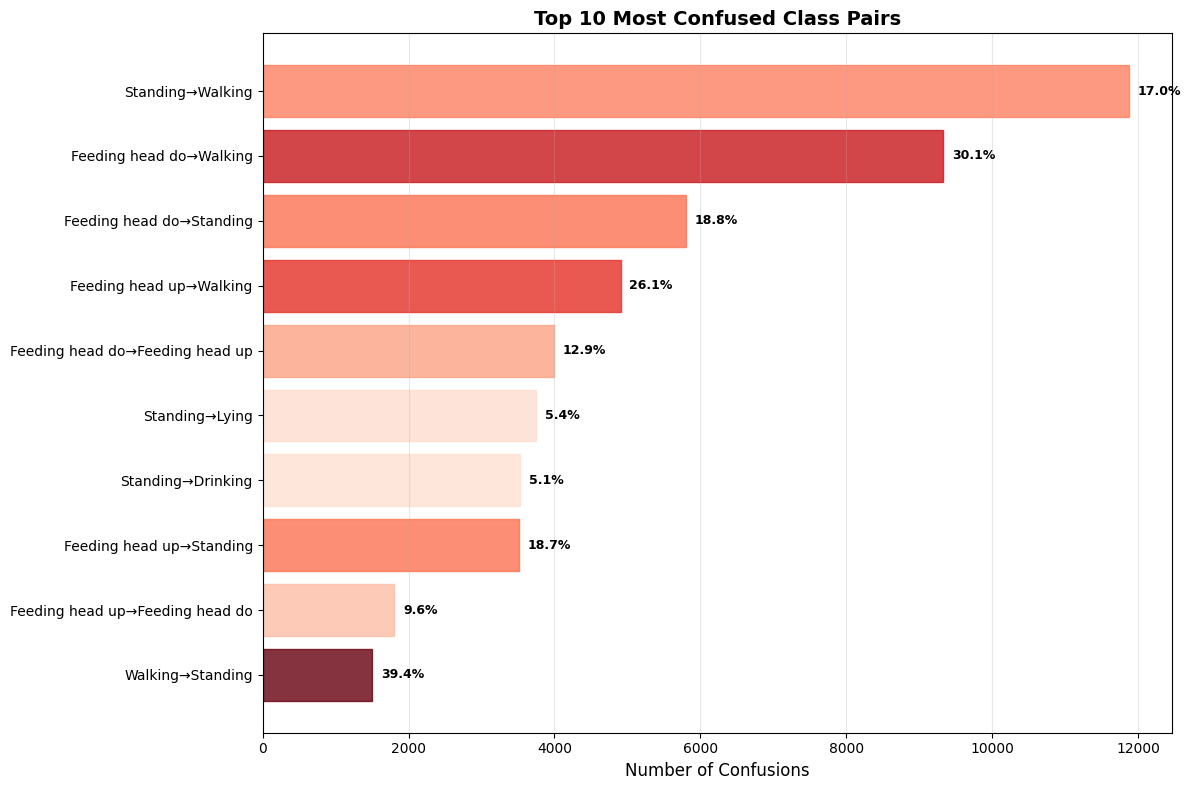


✓ Confusion pairs plot saved: /tmp/resnet18_confusion_pairs.png

STEP 10: PERFORMANCE BY SOURCE

Found 2 source(s): ['mmcows', 'playbehavior']

📊 Performance by Source:
Source               | Samples    | Accuracy   | Precision  | Recall     | F1
------------------------------------------------------------------------------------------
mmcows               | 209881     | 0.7298     | 0.8186     | 0.7298     | 0.7547    
playbehavior         | 1919       | 0.6087     | 0.6660     | 0.6087     | 0.5955    

STEP 11: SAVE RESULTS
✓ Results saved: dbfs:/mnt/playbehavior/Fine_tuning/Processed_Datasets/resnet18_eval_results.json
✓ Predictions saved: dbfs:/mnt/playbehavior/Fine_tuning/Processed_Datasets/resnet18_predictions.csv

STEP 12: LOG TO MLFLOW
✓ All test results logged to MLflow

✅ EVALUATION COMPLETE

Model:                    resnet18
Approach:                 Train from Scratch
MLflow Run:               0e9d0cc98c094c36ad4e67ce32a351f1

TEST SET PERFORMANCE
Overall Accuracy:      

In [0]:
# ============================================================================
# MODULE 12: COMPREHENSIVE EVALUATION ON TEST SET (UNIFIED)
# ============================================================================

import torch
import torch.nn as nn
import torch.nn.functional as F
import random
from torch.utils.data import Dataset, DataLoader
from torchvision import models
from tqdm import tqdm
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import mlflow
import json
import time

# Set random seeds
RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(RANDOM_SEED)

print("✓ Libraries imported for comprehensive evaluation")


# ============================================================================
# SIMPLIFIED DATASET FOR EVALUATION
# ============================================================================

class SimpleTestDataset(Dataset):
    """Simple test dataset without augmentation"""
    
    def __init__(self, df, label_to_idx):
        self.df = df.reset_index(drop=True)
        self.label_to_idx = label_to_idx
        self.idx_to_label = {v: k for k, v in label_to_idx.items()}
        self.num_classes = len(label_to_idx)
        self.transform = AugmentationPipeline(image_size=224, mode='test')
        self._failed = set()
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        if idx in self._failed:
            idx = np.random.randint(0, len(self))
        
        try:
            row = self.df.iloc[idx]
            image = load_image_cv2(row['image_path'])
            
            if image is None:
                self._failed.add(idx)
                return self.__getitem__(np.random.randint(0, len(self)))
            
            label_idx = self.label_to_idx[row['label']]
            image_tensor = self.transform(image)
            
            metadata = {
                'image_path': row['image_path'],
                'label_str': row['label'],
                'source': row.get('source', 'unknown')
            }
            
            return image_tensor, label_idx, metadata
        
        except Exception as e:
            self._failed.add(idx)
            return self.__getitem__(np.random.randint(0, len(self)))


print("✓ Test dataset class defined")


# ============================================================================
# STEP 1: SETUP - DEFINE RUN ID AND LOAD MODEL
# ============================================================================

# ============================================================================
# STEP 1: SETUP - DEFINE RUN ID AND LOAD MODEL (FIXED)
# ============================================================================

print("\n" + "="*60)
print("STEP 1: LOAD MODEL FROM MLFLOW")
print("="*60)

# IMPORTANT: REPLACE WITH YOUR ACTUAL RUN_ID
RUN_ID = '0e9d0cc98c094c36ad4e67ce32a351f1'  # ← UPDATE THIS with your actual run ID

print(f"Using MLflow Run ID: {RUN_ID}")

# Load model from MLflow
print("\nLoading model from MLflow...")
model_uri = f'runs:/{RUN_ID}/model'
loaded_model = mlflow.pytorch.load_model(model_uri)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
loaded_model = loaded_model.to(device)
loaded_model.eval()

print(f"✓ Model loaded and moved to {device}")

# Get model info from MLflow
client = mlflow.tracking.MlflowClient()
run = client.get_run(RUN_ID)
run_params = run.data.params
run_metrics = run.data.metrics

print(f"\nModel Info:")
print(f"  - Model name: {run_params.get('model_name', 'unknown')}")
print(f"  - Training samples: {run_params.get('train_samples', 'unknown')}")

# Handle best_val_acc safely - it might not exist or might be a string
best_val_acc = run_metrics.get('best_val_acc', None)
if best_val_acc is not None:
    try:
        print(f"  - Best val acc: {float(best_val_acc):.4f}")
    except (ValueError, TypeError):
        print(f"  - Best val acc: {best_val_acc}")
else:
    # Try to find the maximum validation accuracy from all metrics
    val_acc_metrics = {k: v for k, v in run_metrics.items() if 'val_acc' in k}
    if val_acc_metrics:
        max_val_acc = max(val_acc_metrics.values())
        print(f"  - Best val acc: {max_val_acc:.4f}")
    else:
        print(f"  - Best val acc: Not available")

print(f"  - Available metrics: {list(run_metrics.keys())[:10]}")  # Show first 10 metrics


# ============================================================================
# STEP 2: WRAP WITH DATAPARALLEL FOR MULTI-GPU INFERENCE
# ============================================================================

print("\n" + "="*60)
print("STEP 2: SETUP PARALLEL INFERENCE")
print("="*60)

num_gpus = torch.cuda.device_count()

if num_gpus > 1:
    print(f"\n✓ Detected {num_gpus} GPUs - enabling DataParallel")
    print(f"  GPUs: {[torch.cuda.get_device_name(i) for i in range(num_gpus)]}")
    
    # Wrap model with DataParallel
    loaded_model = nn.DataParallel(loaded_model)
    
    print(f"✓ Model will use all {num_gpus} GPUs for parallel inference")
    print(f"  Effective batch size per forward pass: {64 * num_gpus}")
else:
    print(f"\n✓ Using single GPU: {torch.cuda.get_device_name(0)}")

loaded_model = loaded_model.to('cuda')
loaded_model.eval()


# ============================================================================
# STEP 3: CREATE TEST DATASET
# ============================================================================

print("\n" + "="*60)
print("STEP 3: CREATE TEST DATASET")
print("="*60)

# Create label mapping
all_labels = sorted(Config.ALL_LABELS)
label_to_idx = {label: idx for idx, label in enumerate(all_labels)}
idx_to_label = {v: k for k, v in label_to_idx.items()}

print(f"\nLabel mapping ({len(label_to_idx)} classes):")
for label, idx in sorted(label_to_idx.items(), key=lambda x: x[1]):
    print(f"  {idx}: {label}")

# Create test dataset
test_dataset = SimpleTestDataset(combined_test_df, label_to_idx)

# Adjust batch size based on number of GPUs
test_batch_size = 64 if num_gpus <= 1 else 64 * num_gpus

test_loader = DataLoader(
    test_dataset,
    batch_size=test_batch_size,
    shuffle=False,
    num_workers=8,
    pin_memory=True,
    drop_last=False
)

print(f"\n✓ Test dataset: {len(test_dataset)} samples")
print(f"✓ Test loader: {len(test_loader)} batches")
print(f"✓ Batch size: {test_batch_size}")


# ============================================================================
# STEP 4: RUN PARALLEL EVALUATION (FIXED)
# ============================================================================

print("\n" + "="*60)
print("STEP 4: RUN PARALLEL EVALUATION")
print("="*60)

all_preds = []
all_labels_list = []
all_metadata = []

print(f"\nProcessing {len(test_loader)} batches with parallel inference...")
print("This will be much faster with multiple GPUs!\n")

start_time = time.time()

loaded_model.eval()

with torch.no_grad():
    for images, labels, metadata_batch in tqdm(test_loader, desc="Evaluating"):
        images = images.to('cuda', non_blocking=True)
        
        # Forward pass with automatic mixed precision
        with torch.cuda.amp.autocast():
            logits = loaded_model(images)
        
        preds = logits.argmax(dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels_list.extend(labels.numpy())
        
        # FIXED: Properly handle metadata batch
        # metadata_batch is a dict of lists (batch_size elements per key)
        batch_size = len(labels)
        for i in range(batch_size):
            # Extract metadata for each sample in the batch
            sample_metadata = {
                'image_path': metadata_batch['image_path'][i],
                'label_str': metadata_batch['label_str'][i],
                'source': metadata_batch['source'][i]
            }
            all_metadata.append(sample_metadata)

eval_time = time.time() - start_time

print(f"\n✓ Evaluation complete!")
print(f"  Total time: {eval_time:.1f}s")
print(f"  Throughput: {len(test_dataset) / eval_time:.1f} images/sec")
print(f"  Time per image: {eval_time / len(test_dataset) * 1000:.2f}ms")
print(f"  Collected {len(all_metadata)} metadata entries")


# ============================================================================
# STEP 5: CALCULATE OVERALL METRICS
# ============================================================================

print("\n" + "="*60)
print("STEP 5: OVERALL TEST SET RESULTS")
print("="*60)

accuracy = accuracy_score(all_labels_list, all_preds)
precision, recall, f1, support = precision_recall_fscore_support(
    all_labels_list, all_preds, average='weighted'
)

print(f"\n{'='*60}")
print("OVERALL METRICS")
print(f"{'='*60}")
print(f"Accuracy:  {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")
print(f"{'='*60}")


# ============================================================================
# STEP 6: DETAILED CLASSIFICATION REPORT
# ============================================================================

print("\n" + "="*60)
print("STEP 6: DETAILED CLASSIFICATION REPORT")
print("="*60 + "\n")

target_names = [idx_to_label[i] for i in range(len(label_to_idx))]
print(classification_report(all_labels_list, all_preds, 
                          target_names=target_names, 
                          digits=4))


# ============================================================================
# STEP 7: CONFUSION MATRICES (COUNTS + NORMALIZED)
# ============================================================================

print("\n" + "="*60)
print("STEP 7: CONFUSION MATRICES")
print("="*60)

cm = confusion_matrix(all_labels_list, all_preds)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Confusion matrix - Counts
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_names, yticklabels=target_names, ax=axes[0],
            cbar_kws={'label': 'Count'}, annot_kws={'size': 10})
axes[0].set_title('Confusion Matrix (Counts)', fontsize=16, fontweight='bold', pad=20)
axes[0].set_ylabel('True Label', fontsize=13)
axes[0].set_xlabel('Predicted Label', fontsize=13)
plt.setp(axes[0].get_xticklabels(), rotation=45, ha='right', fontsize=10)
plt.setp(axes[0].get_yticklabels(), rotation=0, fontsize=10)

# Confusion matrix - Normalized
sns.heatmap(cm_norm, annot=True, fmt='.3f', cmap='Blues',
            xticklabels=target_names, yticklabels=target_names, ax=axes[1],
            cbar_kws={'label': 'Proportion'}, vmin=0, vmax=1, annot_kws={'size': 10})
axes[1].set_title('Confusion Matrix (Normalized)', fontsize=16, fontweight='bold', pad=20)
axes[1].set_ylabel('True Label', fontsize=13)
axes[1].set_xlabel('Predicted Label', fontsize=13)
plt.setp(axes[1].get_xticklabels(), rotation=45, ha='right', fontsize=10)
plt.setp(axes[1].get_yticklabels(), rotation=0, fontsize=10)

plt.tight_layout()
cm_save_path = f'/tmp/{run_params.get("model_name", "model")}_confusion_matrix.png'
plt.savefig(cm_save_path, dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✓ Confusion matrix saved: {cm_save_path}")


# ============================================================================
# STEP 8: PER-CLASS PERFORMANCE ANALYSIS
# ============================================================================

print("\n" + "="*60)
print("STEP 8: PER-CLASS PERFORMANCE")
print("="*60)

p, r, f, s = precision_recall_fscore_support(all_labels_list, all_preds, average=None)

# Create comprehensive per-class plots
fig, axes = plt.subplots(2, 2, figsize=(18, 14))
x = np.arange(len(target_names))
width = 0.25

# [1] Metrics Bar Chart
axes[0, 0].bar(x - width, p, width, label='Precision', alpha=0.8, color='steelblue')
axes[0, 0].bar(x, r, width, label='Recall', alpha=0.8, color='coral')
axes[0, 0].bar(x + width, f, width, label='F1-Score', alpha=0.8, color='seagreen')
axes[0, 0].set_ylabel('Score', fontsize=12)
axes[0, 0].set_title('Per-Class Performance Metrics', fontsize=14, fontweight='bold')
axes[0, 0].set_xticks(x)
axes[0, 0].set_xticklabels(target_names, rotation=45, ha='right', fontsize=9)
axes[0, 0].legend(fontsize=11)
axes[0, 0].set_ylim(0, 1.05)
axes[0, 0].grid(axis='y', alpha=0.3)

# [2] Test Set Distribution
axes[0, 1].bar(x, s, alpha=0.8, color='steelblue')
axes[0, 1].set_ylabel('Number of Samples', fontsize=12)
axes[0, 1].set_title('Test Set Distribution', fontsize=14, fontweight='bold')
axes[0, 1].set_xticks(x)
axes[0, 1].set_xticklabels(target_names, rotation=45, ha='right', fontsize=9)
axes[0, 1].grid(axis='y', alpha=0.3)

for i, v in enumerate(s):
    axes[0, 1].text(i, v + max(s)*0.01, str(int(v)), 
                    ha='center', va='bottom', fontsize=9, fontweight='bold')

# [3] Per-Class Accuracy
class_accuracies = []
for i in range(len(cm)):
    class_acc = cm[i, i] / cm[i].sum() if cm[i].sum() > 0 else 0
    class_accuracies.append(class_acc)

axes[1, 0].bar(x, class_accuracies, alpha=0.8, color='coral')
axes[1, 0].set_ylabel('Accuracy', fontsize=12)
axes[1, 0].set_title('Per-Class Accuracy', fontsize=14, fontweight='bold')
axes[1, 0].set_xticks(x)
axes[1, 0].set_xticklabels(target_names, rotation=45, ha='right', fontsize=9)
axes[1, 0].set_ylim(0, 1.05)
axes[1, 0].axhline(y=accuracy, color='red', linestyle='--', 
                    label=f'Overall Acc: {accuracy:.3f}', linewidth=2)
axes[1, 0].legend(fontsize=11)
axes[1, 0].grid(axis='y', alpha=0.3)

# [4] F1-Score Ranking
f1_sorted_idx = np.argsort(f)
axes[1, 1].barh(np.arange(len(f1_sorted_idx)), f[f1_sorted_idx], alpha=0.8, color='seagreen')
axes[1, 1].set_yticks(np.arange(len(f1_sorted_idx)))
axes[1, 1].set_yticklabels([target_names[i] for i in f1_sorted_idx], fontsize=9)
axes[1, 1].set_xlabel('F1-Score', fontsize=12)
axes[1, 1].set_title('F1-Score Ranking (Worst to Best)', fontsize=14, fontweight='bold')
axes[1, 1].set_xlim(0, 1.05)
axes[1, 1].grid(axis='x', alpha=0.3)

plt.tight_layout()
perf_save_path = f'/tmp/{run_params.get("model_name", "model")}_per_class_performance.png'
plt.savefig(perf_save_path, dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ Per-class performance saved: {perf_save_path}")


# Print detailed per-class table
print("\n" + "="*60)
print("PER-CLASS DETAILED METRICS")
print("="*60)
print(f"{'Class':<30s} | {'Prec':<8s} | {'Recall':<8s} | {'F1':<8s} | {'Acc':<8s} | {'Support'}")
print("-" * 95)

for i in range(len(target_names)):
    print(f"{target_names[i]:<30s} | {p[i]:<8.4f} | {r[i]:<8.4f} | {f[i]:<8.4f} | "
          f"{class_accuracies[i]:<8.4f} | {int(s[i])}")


# ============================================================================
# STEP 9: CONFUSION PAIR ANALYSIS
# ============================================================================

print("\n" + "="*60)
print("STEP 9: CONFUSION PAIR ANALYSIS")
print("="*60)

# Find most confused pairs
pairs = []
for i in range(len(cm)):
    for j in range(len(cm)):
        if i != j and cm[i, j] > 0:
            pairs.append({
                'true': target_names[i],
                'pred': target_names[j],
                'count': cm[i, j],
                'pct': cm[i, j] / cm[i].sum() * 100,
                'true_idx': i,
                'pred_idx': j
            })

pairs.sort(key=lambda x: x['count'], reverse=True)

print("\n📊 Top 15 Most Confused Pairs:")
print(f"{'True Label':<30s} | {'Predicted As':<30s} | {'Count':<8s} | {'% of True'}")
print("-" * 100)

for pair in pairs[:15]:
    print(f"{pair['true']:<30s} | {pair['pred']:<30s} | {pair['count']:<8d} | {pair['pct']:>7.2f}%")


# Visualize top confusion pairs
top_n_pairs = 10
if len(pairs) >= top_n_pairs:
    fig, ax = plt.subplots(figsize=(12, 8))
    
    top_pairs = pairs[:top_n_pairs]
    labels = [f"{p['true'][:15]}→{p['pred'][:15]}" for p in top_pairs]
    counts = [p['count'] for p in top_pairs]
    pcts = [p['pct'] for p in top_pairs]
    
    y_pos = np.arange(len(labels))
    bars = ax.barh(y_pos, counts, alpha=0.8, color='coral')
    
    # Color bars by percentage
    colors = plt.cm.Reds(np.array(pcts) / max(pcts))
    for bar, color in zip(bars, colors):
        bar.set_color(color)
    
    ax.set_yticks(y_pos)
    ax.set_yticklabels(labels, fontsize=10)
    ax.invert_yaxis()
    ax.set_xlabel('Number of Confusions', fontsize=12)
    ax.set_title(f'Top {top_n_pairs} Most Confused Class Pairs', 
                 fontsize=14, fontweight='bold')
    ax.grid(axis='x', alpha=0.3)
    
    # Add percentage labels
    for i, (count, pct) in enumerate(zip(counts, pcts)):
        ax.text(count + max(counts)*0.01, i, f'{pct:.1f}%', 
                va='center', fontsize=9, fontweight='bold')
    
    plt.tight_layout()
    confusion_pairs_path = f'/tmp/{run_params.get("model_name", "model")}_confusion_pairs.png'
    plt.savefig(confusion_pairs_path, dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"\n✓ Confusion pairs plot saved: {confusion_pairs_path}")


# ============================================================================
# STEP 10: PERFORMANCE BY SOURCE (MMcows vs PlayBehavior)
# ============================================================================

print("\n" + "="*60)
print("STEP 10: PERFORMANCE BY SOURCE")
print("="*60)

# Extract source from metadata (now correctly formatted)
sources = [m['source'] for m in all_metadata]
unique_sources = sorted(set(sources))

print(f"\nFound {len(unique_sources)} source(s): {unique_sources}")

# Calculate metrics per source
source_metrics = {}

for source in unique_sources:
    source_mask = [s == source for s in sources]
    source_labels = [l for l, m in zip(all_labels_list, source_mask) if m]
    source_preds = [p for p, m in zip(all_preds, source_mask) if m]
    
    if len(source_labels) > 0:
        source_acc = accuracy_score(source_labels, source_preds)
        source_p, source_r, source_f, _ = precision_recall_fscore_support(
            source_labels, source_preds, average='weighted', zero_division=0
        )
        
        source_metrics[source] = {
            'accuracy': source_acc,
            'precision': source_p,
            'recall': source_r,
            'f1': source_f,
            'samples': len(source_labels)
        }

print("\n📊 Performance by Source:")
print(f"{'Source':<20s} | {'Samples':<10s} | {'Accuracy':<10s} | {'Precision':<10s} | {'Recall':<10s} | {'F1'}")
print("-" * 90)

for source, metrics in source_metrics.items():
    print(f"{source:<20s} | {metrics['samples']:<10d} | {metrics['accuracy']:<10.4f} | "
          f"{metrics['precision']:<10.4f} | {metrics['recall']:<10.4f} | {metrics['f1']:<10.4f}")


# ============================================================================
# STEP 11: SAVE COMPREHENSIVE RESULTS
# ============================================================================

print("\n" + "="*60)
print("STEP 11: SAVE RESULTS")
print("="*60)

# Create comprehensive results dictionary
results = {
    'model': run_params.get('model_name', 'unknown'),
    'approach': 'train_from_scratch',
    'source': 'mlflow',
    'run_id': RUN_ID,
    'training_config': dict(run_params),
    
    # Overall metrics
    'overall': {
        'accuracy': float(accuracy),
        'precision': float(precision),
        'recall': float(recall),
        'f1': float(f1),
        'test_samples': len(all_labels_list),
        'inference_time_sec': float(eval_time),
        'throughput_imgs_per_sec': float(len(test_dataset) / eval_time)
    },
    
    # Per-class metrics
    'per_class': {},
    
    # Per-source metrics
    'per_source': source_metrics,
    
    # Confusion pairs
    'top_confused_pairs': [
        {
            'true_label': pair['true'],
            'predicted_label': pair['pred'],
            'count': int(pair['count']),
            'percentage': float(pair['pct'])
        }
        for pair in pairs[:20]
    ],
    
    # Confusion matrix
    'confusion_matrix': cm.tolist(),
    'confusion_matrix_normalized': cm_norm.tolist()
}

# Add per-class details
for i, label in enumerate(target_names):
    results['per_class'][label] = {
        'precision': float(p[i]),
        'recall': float(r[i]),
        'f1': float(f[i]),
        'accuracy': float(class_accuracies[i]),
        'support': int(s[i])
    }

# Save to JSON
model_name = run_params.get('model_name', 'model')
results_path = dbfs_to_local(f"{Config.OUTPUT_BASE}/{model_name}_eval_results.json")
os.makedirs(os.path.dirname(results_path), exist_ok=True)

with open(results_path, 'w') as f:
    json.dump(results, f, indent=2)

print(f"✓ Results saved: {local_to_dbfs(results_path)}")


# Save predictions to CSV
predictions_df = pd.DataFrame({
    'image_path': [m['image_path'] for m in all_metadata],
    'true_label': [idx_to_label[l] for l in all_labels_list],
    'predicted_label': [idx_to_label[p] for p in all_preds],
    'correct': [l == p for l, p in zip(all_labels_list, all_preds)],
    'source': [m['source'] for m in all_metadata]
})

predictions_csv_path = dbfs_to_local(f"{Config.OUTPUT_BASE}/{model_name}_predictions.csv")
predictions_df.to_csv(predictions_csv_path, index=False)

print(f"✓ Predictions saved: {local_to_dbfs(predictions_csv_path)}")


# ============================================================================
# STEP 12: LOG TO MLFLOW
# ============================================================================

print("\n" + "="*60)
print("STEP 12: LOG TO MLFLOW")
print("="*60)

with mlflow.start_run(run_id=RUN_ID):
    # Log test metrics
    mlflow.log_metrics({
        'test_accuracy': accuracy,
        'test_precision': precision,
        'test_recall': recall,
        'test_f1': f1,
        'test_samples': len(all_labels_list),
        'inference_time_sec': eval_time,
        'throughput_imgs_per_sec': len(test_dataset) / eval_time
    })
    
    # Log per-source metrics
    for source, metrics in source_metrics.items():
        mlflow.log_metrics({
            f'test_{source}_accuracy': metrics['accuracy'],
            f'test_{source}_f1': metrics['f1'],
            f'test_{source}_samples': metrics['samples']
        })
    
    # Log plots
    mlflow.log_artifact(cm_save_path, "test_results")
    mlflow.log_artifact(perf_save_path, "test_results")
    if len(pairs) >= 10:
        mlflow.log_artifact(confusion_pairs_path, "test_results")
    
    # Log results files
    mlflow.log_artifact(results_path, "test_results")
    mlflow.log_artifact(predictions_csv_path, "test_results")
    
    print("✓ All test results logged to MLflow")


# ============================================================================
# FINAL SUMMARY
# ============================================================================

print("\n" + "="*60)
print("✅ EVALUATION COMPLETE")
print("="*60)

print(f"\n{'Model:':<25s} {run_params.get('model_name', 'unknown')}")
print(f"{'Approach:':<25s} Train from Scratch")
print(f"{'MLflow Run:':<25s} {RUN_ID}")

print(f"\n{'='*60}")
print("TEST SET PERFORMANCE")
print(f"{'='*60}")
print(f"{'Overall Accuracy:':<25s} {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"{'Overall F1-Score:':<25s} {f1:.4f}")
print(f"{'Test Samples:':<25s} {len(all_labels_list):,}")
print(f"{'Inference Time:':<25s} {eval_time:.1f}s")
print(f"{'Throughput:':<25s} {len(test_dataset) / eval_time:.1f} images/sec")

print(f"\n{'='*60}")
print("BEST/WORST PERFORMING CLASSES")
print(f"{'='*60}")